# Kavee
## Purchase Data - Exploration

We start with the original dataset and produce a cleaned version, using the following assumptions:
- Only keep status=PAID rows (Removing 5.81% (11.4k from 195.9k rows), resulting in 0.08% revenue loss)
- Only keep rows where ProcessedDate exists (Removing 1.56% (2.9k from 184.5k rows), resulting in 1.84% revenue loss)
- Only keep rows where ProcessedDate is less than 30 days after (Removing 0.03% (0.1k from 181.6k rows), resulting in 0.02% revenue loss)
- Only keep rows where the user has an email address (Removing 0.00% (0.0k from 181.5k rows), resulting in 0.00% revenue loss)
- Convert all currencies into GBP
- Only keep rows where revenue is positive (Removing 0.51% (0.9k from 181.5k rows), resulting in 0.00% revenue loss)
- Keeping loss making rows where cost>revenue for now (0.49% (0.9k from 180.6k rows), which would result in 0.06% revenue loss)
- Removing orders from Amazon as they are not trackable (email=Redacted) (Removing 2.40% (4.3k from 180.6k rows), resulting in 3.88% revenue loss)

This cleaning has the following impact, which seems acceptable:
- Original : 195.87k rows - 55.90k users - 103.28k orders - 12.525m revenue
- Cleaned : 176.28k rows - 54.93k users - 90.66k orders - 11.805m revenue

We then create an order level dataset, that groups the basket purchases together
- About 20% of orders happen as a same-day follow up order. For the purpose of customer analysis, these rapid-fire orders are grouped into a single order
- The final orders dataset (orders.csv) contains the following information:
    - email
    - orderId (which can be a concatenation, for the rapid-fire same-day orders)
    - date
    - month
    - order spend
    - number of items
    - concatenation of items description
    - order number (ie customer first order, second, etc)
    - LTV so far
    - days since last order
    - everything bought so far : all items purchased in the customer history
    - date joined (date of first purchase)
    - days since joined
    - AOV so far
    - cluster name (more on that later)
    
Now we can build a simple categorisation of customers, inspired by RFM
- Recency : when did they last order?           ---> days_since_last_order
- Frequency : how often do they order?          ---> order_number
- Monetary : how much did they spend in total?  ---> LTV_so_far
- AOV : how much do they spend on average       ---> aov_so_far
- Loyalty : which month did they first join?    ---> days_since_joined
Potentially interesting to later also look at
- Items : what did they buy?                    ---> items, everything_bought_so_far

The resulting five clusters have the following characteristics
-         0: 'newbie low',           # new customer, low spend
-         1: 'lapsed returning',     # older cohort, infrequent large orders
-         2: 'habitual high',        # recent customer, frequent large orders
-         3: 'fresh returning high', # very recent new customer, high spender
-         4: 'newbie high'           # new customer, very high spend

We can then track their contribution to revenue and follow the customer journey, as they move across clusters.


In [307]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import sparse

from tqdm.notebook import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

def percentile(n):
    def fun(x):
        return np.percentile(x,n)
    fun.__name__ = f'perc_{n}'
    return fun

def plot_bands(df,date_col,field,title,perc_min=16,perc_max=84,median=True,mean=True,rotation=90,figsize=(12,4)):
    summary = df.groupby(date_col)[field].agg(['mean','min','max',percentile(perc_min),percentile(50),percentile(perc_max)])
    fig, ax = plt.subplots(figsize=figsize)
    if median: ax.plot(summary.index, summary['perc_50'], '-',label='median')
    if mean: ax.plot(summary.index, summary['mean'], 'o', color='tab:brown',label='mean')
    ax.fill_between(summary.index, summary[f'perc_{perc_min}'], summary[f'perc_{perc_max}'], alpha=0.2,label=f'perc_{perc_min}_to_{perc_max}')
    ax.legend()
    plt.title(title)
    plt.xticks(rotation=rotation)
    return summary


In [308]:
path = r'C:/Users/skand/Downloads/QueryData-21-08-23(10_27_19).csv'

## Loading

In [312]:
original = pd.read_csv(path)
print('%s orders with %s columns' % original.shape)
print('Columns:',original.columns)
print('Example:',original.iloc[0].to_dict())
original.sample(10)

195865 orders with 38 columns
Columns: Index(['nOrderId', 'ReferenceNum', 'ExternalReference', 'ChannelReference',
       'Company', 'cFullName', 'cEmailAddress', 'cPostCode', 'dReceievedDate',
       'Country', 'status', 'Processed', 'ProcessedDate', 'Source',
       'SubSource', 'Currency', 'PostageCosts', 'Subtotal', 'PostageCostExTax',
       'CountryTaxRate', 'Total', 'Tax', 'OrderItemSKU', 'OrderItemId',
       'OrderItemTitle', 'ItemCategory', 'OrderItemQuantity',
       'OrderItemSalesTax', 'OrderItemTaxRate', 'OrderItemCostExTax',
       'OrderItemCostIncTax', 'DispatchStockUnitCost', 'TotalWeight',
       'PurchasePrice', 'TrackingNumber', 'PostalService', 'Payment Method',
       'BuyerPhoneNumber'],
      dtype='object')
Example: {'nOrderId': 222899, 'ReferenceNum': '5313330970855', 'ExternalReference': '36421', 'ChannelReference': '36421UK', 'Company': nan, 'cFullName': 'Courtney Marshall', 'cEmailAddress': 'courtneyannexx@hotmail.com', 'cPostCode': 'DE7 6GE', 'dReceievedD

,nOrderId,ReferenceNum,ExternalReference,ChannelReference,Company,cFullName,cEmailAddress,cPostCode,dReceievedDate,Country,...,OrderItemTaxRate,OrderItemCostExTax,OrderItemCostIncTax,DispatchStockUnitCost,TotalWeight,PurchasePrice,TrackingNumber,PostalService,Payment Method,BuyerPhoneNumber
85211,232067,5369216336042,38568,38568USA,NaN,Jen O'Herron,joherron27@gmail.com,44310,17/07/2023 03:34:42,United States,...,0.0,16.500000,16.5,1.714647,2.6950,1.780000,781335613860,FedEx Wwide - Economy,Shopify USA - ClearPay,+13303298604
178261,235926,5425521230055,39462,39462UK,NaN,Amy Stirton,amystirton@hotmail.com,OX15 4BA,16/08/2023 21:55:03,United Kingdom,...,20.0,30.833333,37.0,5.138982,20.6267,4.270000,782600252980,Fedex Economy - Europe,Shopify UK - Stripe,07713 283072
9934,212954,5220346659047,33176,33176UK,NaN,Sarah Cross,sarahjcross1@gmail.com,BH17 9EL,20/03/2023 18:47:06,United Kingdom,...,20.0,73.333333,88.0,0.000000,6.5655,18.537940,396009276470,FedEx Wwide - Economy,Shopify UK - Stripe,07808210889
14576,226566,5318227853482,37241,37241USA,NaN,Jenna Jimenez Garcia,guitarchica10@gmail.com,53188,21/06/2023 14:06:30,United States,...,0.0,168.000000,168.0,0.000000,9.6402,17.181951,780251407568,FedEx Wwide - Economy,Shopify USA - ClearPay,(262) 408-0853
191959,191165,4932933157103,18142,#18142,NaN,Contratto Stefano,stefano.contratto@gmail.com,93400,18/10/2022 08:43:06,France,...,20.0,29.166667,35.0,0.000000,1.2990,1.000000,279316686980,FedEx Wwide - Economy,Shopify FR - Stripe,+33 7 81 59 77 44
29137,183120,4880806641895,24706,24706UK,NaN,Victoria Kind,victoria_kind@hotmail.com,LE10 2FQ,11/08/2022 14:57:33,United Kingdom,...,20.0,16.666667,20.0,2.046598,13.4213,1.900000,276828208950,Fedex Economy - Europe,Shopify UK - Paypal,07973291704
134728,182967,4856235458799,17014,#17014,NaN,Stephanie De ridder,stephanie.deridder19@laposte.net,59500,10/08/2022 11:04:35,France,...,20.0,18.333333,22.0,2.318139,1.5300,1.000000,276646814290,FedEx Wwide - Economy,Shopify FR - Paypal,06 50 28 11 74
29823,180178,4833040433391,16706,#16706,NaN,Eva Frangione,carolinejelsch@yahoo.fr,25660,17/07/2022 10:28:31,France,...,20.0,40.000000,48.0,0.000000,5.1300,1.000000,275998539674,Fedex Economy - Europe,Shopify FR - Stripe,06 32 46 21 35
169913,200571,5042833883375,19316,#19316,NaN,Blondeau Emilie,em.blondeau31@gmail.com,32130,23/12/2022 21:13:34,France,...,20.0,67.500000,81.0,0.000000,2.4000,16.100000,392687571519,FedEx Wwide - Economy,Shopify FR - Stripe,+33 6 74 28 45 62
36141,224197,5595556512092,22431,#22431,NaN,Arnaud Bovière,applecool24@hotmail.fr,75013,29/05/2023 19:37:37,France,...,20.0,35.000000,42.0,4.539487,1.7420,4.500000,398917461938,FedEx Wwide - Economy,Shopify FR - Stripe,0667381217


In [313]:
original['date'] = pd.to_datetime(original['dReceievedDate'],format='%d/%m/%Y %H:%M:%S').dt.date

<AxesSubplot:title={'center':'Number of (email,date) combo where N orders were placed'}>

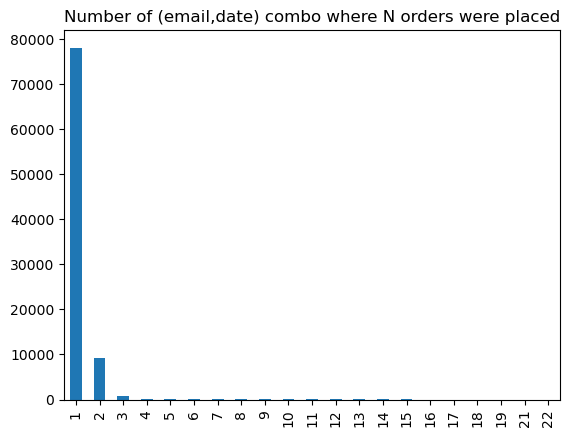

In [314]:
dups = original.groupby(['cEmailAddress','date'])['nOrderId'].nunique().value_counts()
dups.sort_index().plot.bar(title='Number of (email,date) combo where N orders were placed')

## Cleaning

In [315]:
revenue_col = 'OrderItemCostIncTax'

def remove(df,mask,revenue_col=revenue_col,replace=True):
    revenue = df[revenue_col].sum()
    keep = df[mask]
    missing = revenue-keep[revenue_col].sum()
    print(f'Removing {((~mask).mean()*100):.2f}% ({((~mask).sum()/1000):.1f}k from {(df.shape[0]/1000):.1f}k rows), resulting in {(100*missing/revenue):.2f}% revenue loss')
    return keep if replace else df

### Status column

In [316]:
status = original.groupby('status').agg({revenue_col:['count','sum']})
status/status.sum()

OrderItemCostIncTax          
                     count       sum
status                              
PAID              0.941894  0.999184
RESEND            0.033809  0.000099
UNPAID            0.024297  0.000717

Assumption : we only look at status=PAID

In [317]:
mask = original['status'] == 'PAID'
clean = remove(original,mask)

Removing 5.81% (11.4k from 195.9k rows), resulting in 0.08% revenue loss


In [318]:
date_cols = 'dReceievedDate ProcessedDate'.split()
date_col = 'dReceievedDate'
for col in date_cols:
    clean[col] = pd.to_datetime(clean[col],format='%d/%m/%Y %H:%M:%S')
    print(f'no data in {col} : {100*clean[col].isnull().mean():.2f}%')

no data in dReceievedDate : 0.00%
no data in ProcessedDate : 1.56%


Assumption : we only look at data where ProcessedDate exists

In [319]:
mask = ~clean['ProcessedDate'].isnull()
clean = remove(clean,mask)

Removing 1.56% (2.9k from 184.5k rows), resulting in 1.84% revenue loss


In [320]:
clean['month'] = clean[date_col].to_numpy().astype('datetime64[M]')

Text(0.5, 1.0, 'Days from dReceievedDate to ProcessedDate')

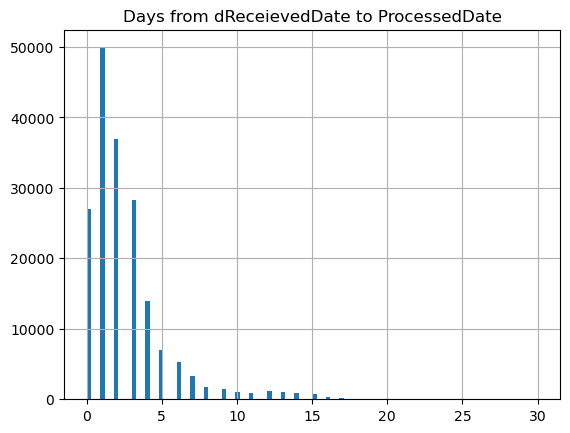

In [321]:
clean['date_lag'] = ((clean['ProcessedDate'] - clean['dReceievedDate'])/np.timedelta64(1,'D')).astype(int)
clean['date_lag'].hist(bins=100,range=(0,30))
plt.title('Days from dReceievedDate to ProcessedDate')

Assumption : we only look at data where ProcessedDate occurs: between [0,30] days *after* dReceievedDate

In [322]:
mask = (clean['date_lag']>=0) & (clean['date_lag']<=30)
clean = remove(clean,mask)

Removing 0.03% (0.1k from 181.6k rows), resulting in 0.02% revenue loss


In [323]:
email_col = 'cEmailAddress'

print(f'no email address: {100*clean[email_col].isnull().mean():.4f}%')

no email address: 0.0006%


Assumption : we need an email address

In [324]:
mask = ~clean[email_col].isnull()
clean = remove(clean,mask)

Removing 0.00% (0.0k from 181.5k rows), resulting in 0.00% revenue loss


## Money matters

In [325]:
clean['Currency Country Total Subtotal OrderItemQuantity CountryTaxRate Tax OrderItemSalesTax OrderItemCostExTax OrderItemCostIncTax PurchasePrice'.split()].sample(10)

,Currency,Country,Total,Subtotal,OrderItemQuantity,CountryTaxRate,Tax,OrderItemSalesTax,OrderItemCostExTax,OrderItemCostIncTax,PurchasePrice
25029,GBP,United Kingdom,222.00,185.000000,1,20.0,37.000000,11.666667,58.333333,70.00,11.200000
44122,GBP,United Kingdom,281.25,234.375000,1,20.0,46.875000,3.375000,16.875000,20.25,14.848903
109513,USD,United States,486.00,486.000000,2,0.0,0.000000,0.000000,86.400000,86.40,4.460000
92367,EUR,Germany,72.00,60.504202,1,19.0,11.495798,3.193277,16.806723,20.00,1.680000
156778,USD,United States,47.00,40.000000,1,0.0,0.000000,0.000000,40.000000,40.00,4.235776
44266,GBP,United Kingdom,94.00,78.333333,1,20.0,15.666667,3.000000,15.000000,18.00,1.780000
67895,USD,United States,192.00,192.000000,1,0.0,0.000000,0.000000,48.000000,48.00,4.460000
122232,USD,United States,344.00,344.000000,2,0.0,0.000000,0.000000,162.000000,162.00,8.790000
59413,EUR,Belgium,59.20,43.140496,1,21.0,10.274380,2.186777,10.413223,12.60,0.810000
28614,USD,United States,146.00,146.000000,1,0.0,0.000000,0.000000,146.000000,146.00,26.143194


Assumption:
- OrderItemCostIncTax is Revenue
- PurchasePrice is Cost
- All figures are in local Currency

### We need to convert to GBP

<AxesSubplot:title={'center':'# orders by currency'}>

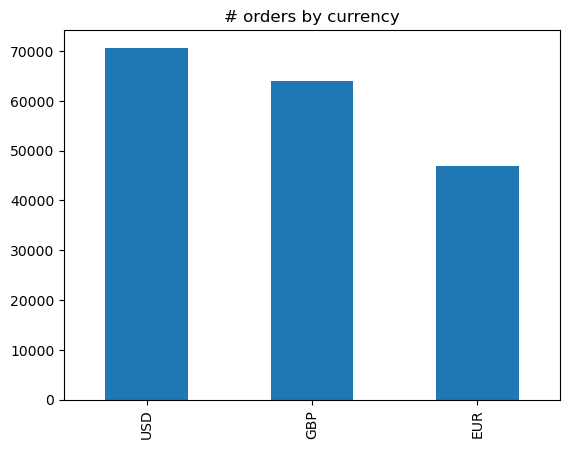

In [326]:
clean['Currency'].value_counts().plot.bar(title='# orders by currency')

In [327]:
exchange_rates = {'EUR':0.85, 'USD':0.79, 'GBP':1.}

In [328]:
clean['exchange_rate'] = clean['Currency'].replace(exchange_rates)
cost_col = 'PurchasePrice'
clean['cost'] = clean[cost_col] * clean['exchange_rate']
clean['revenue'] = clean[revenue_col] * clean['exchange_rate']
clean['Currency Country OrderItemCostIncTax PurchasePrice cost revenue exchange_rate'.split()].groupby('Currency').apply(lambda df: df.sample(5))

Currency         Country  OrderItemCostIncTax  PurchasePrice  \
Currency                                                                       
EUR      30123       EUR          France                 21.6         1.6800   
         7430        EUR         Belgium                 37.0         4.2400   
         156496      EUR     Switzerland                 26.0         3.4625   
         126228      EUR          France                 15.0         0.8100   
         55168       EUR         Germany                 66.0        12.1200   
GBP      8218        GBP  United Kingdom                 71.0        11.2000   
         94358       GBP  United Kingdom                 16.0         0.8100   
         129224      GBP  United Kingdom                 20.0         1.7800   
         58401       GBP  United Kingdom                 10.0         1.7800   
         58230       GBP  United Kingdom                 21.0         2.0200   
USD      91706       USD   United States                 86.0         1.0000   
         136614      USD           Qatar                 91.0        11.2000   
         69090       USD   United States                 56.0         1.0000   
         104059      USD   United States                109.8         6.3300   
         10683       USD   United States                 33.0         1.2100   

                      cost  revenue  exchange_rate  
Currency                                            
EUR      30123    1.428000   18.360           0.85  
         7430     3.604000   31.450           0.85  
         156496   2.943125   22.100           0.85  
         126228   0.688500   12.750           0.85  
         55168   10.302000   56.100           0.85  
GBP      8218    11.200000   71.000           1.00  
         94358    0.810000   16.000           1.00  
         129224   1.780000   20.000           1.00  
         58401    1.780000   10.000           1.00  
         58230    2.020000   21.000           1.00  
USD      91706    0.790000   67.940           0.79  
         136614   8.848000   71.890           0.79  
         69090    0.790000   44.240           0.79  
         104059   5.000700   86.742           0.79  
         10683    0.955900   26.070           0.79

Text(0.5, 1.0, 'Markups seem high : is this correct ?')

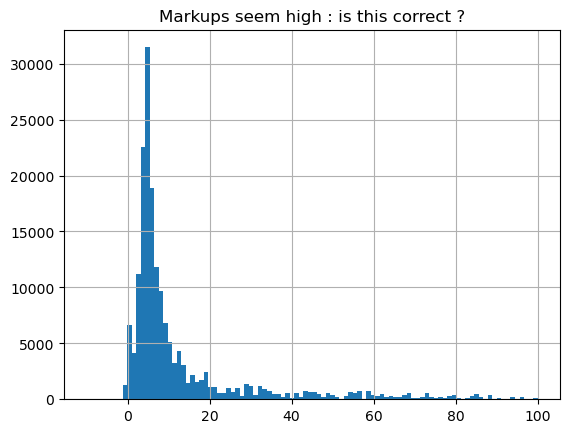

In [329]:
(clean['OrderItemCostIncTax'] / clean['PurchasePrice'] - 1).hist(range=(-10,100),bins=100)
plt.title('Markups seem high : is this correct ?')

Assumption : Revenue needs to be positive

In [330]:
mask = clean['revenue'] > 0
clean = remove(clean,mask)

Removing 0.51% (0.9k from 181.5k rows), resulting in 0.00% revenue loss


Assumption : Revenue needs to be greater than cost (I won't remove these for now)

In [331]:
mask = clean['revenue'] >= clean['cost']
_ = remove(clean,mask,replace=False)

Removing 0.49% (0.9k from 180.6k rows), resulting in 0.06% revenue loss


In [332]:
display(clean['nOrderId'].value_counts().value_counts())

1     55050
2     19596
3      9200
4      4616
5      2581
6      1463
7       806
8       508
9       295
10      177
11      113
12       66
13       44
14       34
15       28
16       16
17       10
18        8
19        7
21        4
20        3
36        1
25        1
26        1
30        1
40        1
Name: nOrderId, dtype: int64

Checking a large order with multiple items : 'nOrderId' == 140902

In [333]:
clean[clean['nOrderId'] == 140902]['Currency Country Total Subtotal OrderItemQuantity CountryTaxRate Tax OrderItemSalesTax OrderItemCostExTax OrderItemCostIncTax PurchasePrice'.split()]

,Currency,Country,Total,Subtotal,OrderItemQuantity,CountryTaxRate,Tax,OrderItemSalesTax,OrderItemCostExTax,OrderItemCostIncTax,PurchasePrice
107192,EUR,France,417.0,347.5,1,20.0,69.5,11.000000,55.000000,66.0,11.200000
107193,EUR,France,417.0,347.5,4,20.0,69.5,9.333333,46.666667,56.0,0.810000
107194,EUR,France,417.0,347.5,1,20.0,69.5,7.000000,35.000000,42.0,1.000000
107195,EUR,France,417.0,347.5,4,20.0,69.5,9.333333,46.666667,56.0,0.810000
107196,EUR,France,417.0,347.5,1,20.0,69.5,3.333333,16.666667,20.0,1.570000
107197,EUR,France,417.0,347.5,1,20.0,69.5,4.166667,20.833333,25.0,12.900628
107198,EUR,France,417.0,347.5,1,20.0,69.5,3.666667,18.333333,22.0,1.680000
107199,EUR,France,417.0,347.5,3,20.0,69.5,11.000000,55.000000,66.0,1.680000
107200,EUR,France,417.0,347.5,1,20.0,69.5,4.166667,20.833333,25.0,12.900628
107201,EUR,France,417.0,347.5,1,20.0,69.5,3.000000,15.000000,18.0,1.210000


Assumption :
- Total is the sum of all {OrderItemCostIncTax} for a given nOrderId
- SubTotal is the sum of all {OrderItemCostExTax} for a given nOrderId

In [334]:
# checking all unique nOrderId have a unique dReceievedDate

clean.groupby('nOrderId')['dReceievedDate'].nunique().value_counts()

# this is true

1    94630
Name: dReceievedDate, dtype: int64

In [335]:
clean[email_col].value_counts()[:5]

Redacted                        4342
info@piglo.net                   211
smallpetwarehouse@gmail.com      102
charli.granger@hotmail.co.uk      80
niomieoconnor@gmail.com           71
Name: cEmailAddress, dtype: int64

In [336]:
mask = clean[email_col] == 'Redacted'
redacted_rev = clean[mask][revenue_col].sum()
print(f'The user "Redacted" accounts for {(redacted_rev/1000):.2f}k of revenue ({(100*redacted_rev/clean[revenue_col].sum()):.1f}%).')

The user "Redacted" accounts for 476.97k of revenue (3.9%).


In [337]:
clean[mask]['Source'].value_counts()

AMAZON    4342
Name: Source, dtype: int64

In [338]:
# All Redacted is Amazon
# Is all Amazon Redacted ?

clean[clean['Source'] == 'AMAZON'][email_col].value_counts()

Redacted    4342
Name: cEmailAddress, dtype: int64

In [339]:
# It is all Amazon : we cannot track the customer IDs, and it only accounts for 4% of revenue.
# Removing it for now.

clean = remove(clean,~mask)

Removing 2.40% (4.3k from 180.6k rows), resulting in 3.88% revenue loss


## Sources

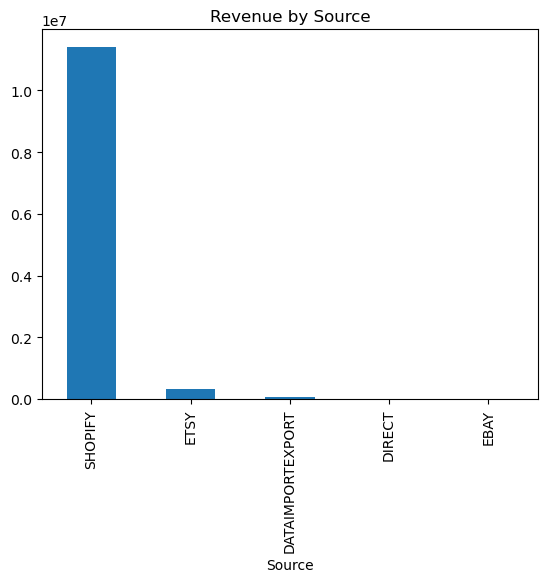

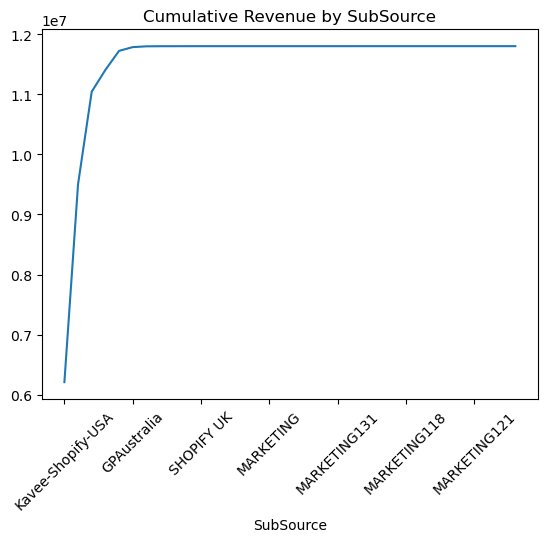

In [340]:
_ = clean.groupby('Source')[revenue_col].sum().sort_values(ascending=False).plot.bar(title='Revenue by Source') 
plt.show()
_ = clean.groupby('SubSource')[revenue_col].sum().sort_values(ascending=False).cumsum().plot(title='Cumulative Revenue by SubSource') 
_ = plt.xticks(rotation=45)

In [341]:
print(f'{100*(clean.groupby(email_col)["SubSource"].nunique() == 1).mean():.2f}% of customers shop through a single SubSource')

98.66% of customers shop through a single SubSource


## Products

<AxesSubplot:title={'center':'monthly sales by SKU category'}, xlabel='month'>

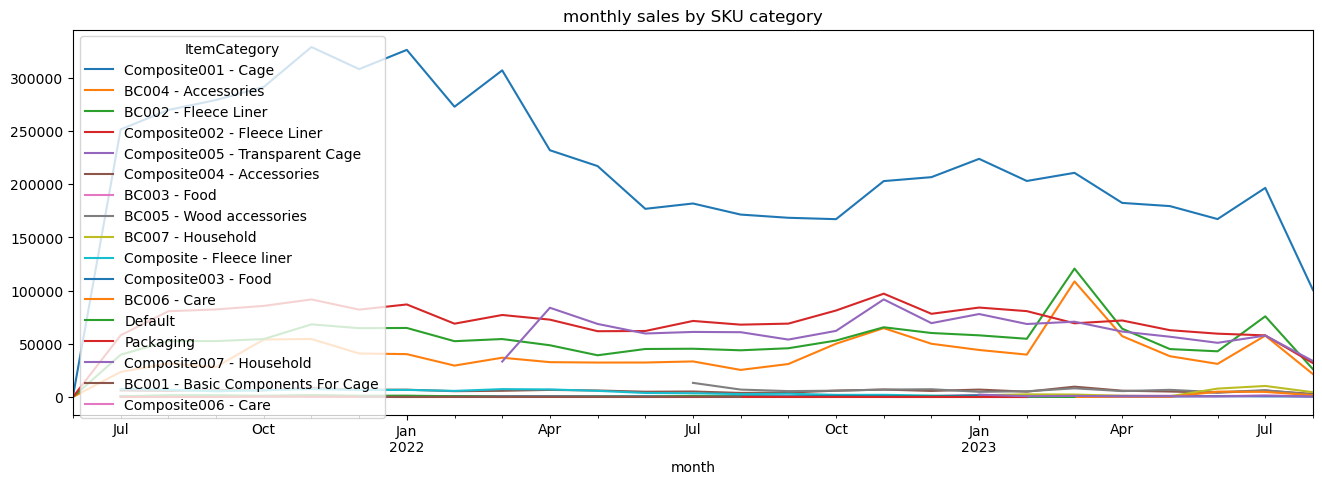

In [342]:
category_col = 'ItemCategory'
top_categories = clean[category_col].value_counts().index
clean.groupby(['month',category_col])[revenue_col].sum().unstack()[top_categories].plot(title='monthly sales by SKU category', figsize=(16,5))

In [343]:
top_countries = clean.groupby('Country')[revenue_col].sum().sort_values(ascending=False) / clean[revenue_col].sum()
display(top_countries[:20])

top_countries = top_countries.index[:5]

Country
United States     0.526708
United Kingdom    0.250046
France            0.106874
Germany           0.028380
Canada            0.019273
Belgium           0.012983
Australia         0.012959
Switzerland       0.006597
Ireland           0.004215
Netherlands       0.003369
Denmark           0.002978
Finland           0.002744
Sweden            0.002673
Norway            0.001960
New Zealand       0.001797
Iceland           0.001641
Luxembourg        0.001338
Spain             0.001246
Italy             0.001242
Austria           0.001232
Name: OrderItemCostIncTax, dtype: float64

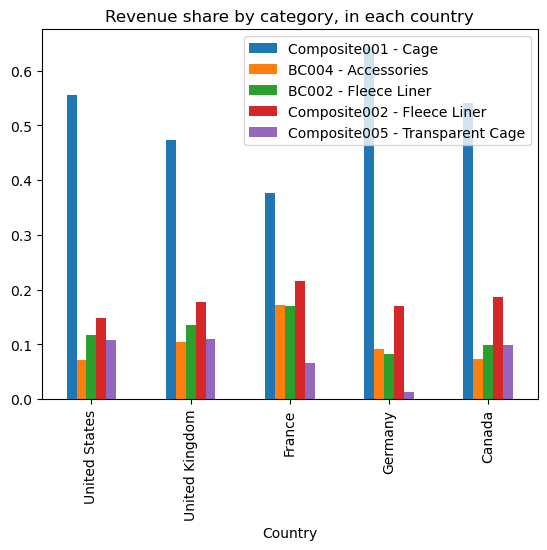

<AxesSubplot:title={'center':'Revenue share by country, in each category'}>

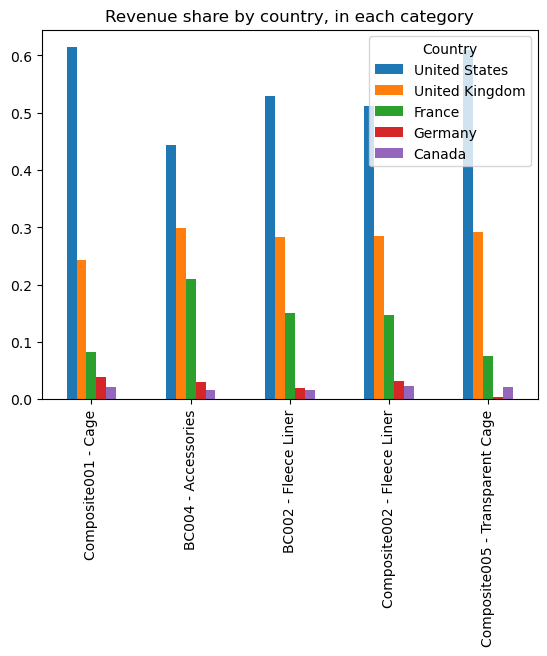

In [344]:
summary_sales_country_cat = clean.groupby([category_col,'Country'])[revenue_col].sum().unstack()[top_countries].loc[top_categories[:5]].astype(int)

(summary_sales_country_cat/summary_sales_country_cat.sum()).T.plot.bar(title='Revenue share by category, in each country')
plt.show()

(summary_sales_country_cat.T/summary_sales_country_cat.T.sum()).T.plot.bar(title='Revenue share by country, in each category')

## Some checks

In [345]:
datetime_col = 'dReceievedDate'
clean['date'] = clean[datetime_col].dt.date

In [346]:
def prettify_columns(ts):
    ts.columns = map('_'.join,ts.columns)
    
ts = clean.groupby('date').agg({revenue_col:['sum','count'],email_col:'nunique'})
prettify_columns(ts)

ts

,OrderItemCostIncTax_sum,OrderItemCostIncTax_count,cEmailAddress_nunique
date,,,
2021-06-30,812.000,8,6
2021-07-01,14043.930,206,98
2021-07-02,13164.132,189,97
2021-07-03,14096.000,205,94
2021-07-04,14899.820,215,106
...,...,...,...
2023-08-14,11865.110,163,84
2023-08-15,13247.240,197,94
2023-08-16,13067.030,175,94


Text(0.5, 1.0, 'Daily Revenue : anything special about the outliers?')

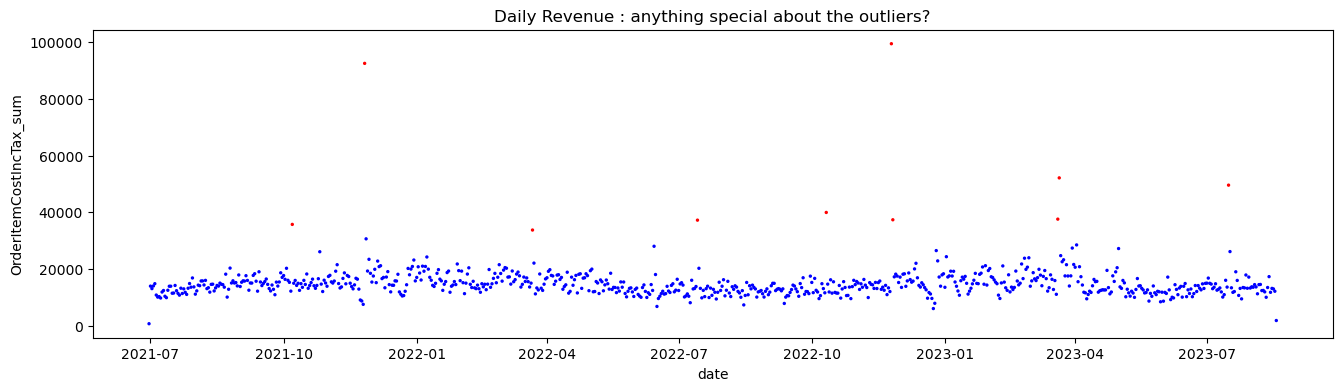

In [347]:
ts['col'] = 'b'
outliers_mask = ((ts['OrderItemCostIncTax_sum']-ts['OrderItemCostIncTax_sum'].mean())/ts['OrderItemCostIncTax_sum'].std())>3
ts.loc[outliers_mask,'col'] = 'r'
ts.reset_index().plot.scatter(x='date', y='OrderItemCostIncTax_sum',figsize=(16,4),s=2,c=ts['col'])
plt.title(f'Daily Revenue : anything special about the outliers?')

In [348]:
ts[outliers_mask]

,OrderItemCostIncTax_sum,OrderItemCostIncTax_count,cEmailAddress_nunique,col
date,,,,
2021-10-07,35764.8900,953,241,r
2021-11-26,92436.1375,1920,540,r
2022-03-22,33783.7500,567,246,r
2022-07-14,37263.4600,713,257,r
2022-10-11,39971.3500,865,297,r
2022-11-25,99350.8430,1826,537,r
2022-11-26,37390.2500,589,227,r
2023-03-20,37619.9600,1379,392,r
2023-03-21,52139.2500,1977,571,r


Text(0.5, 1.0, 'Unique Items')

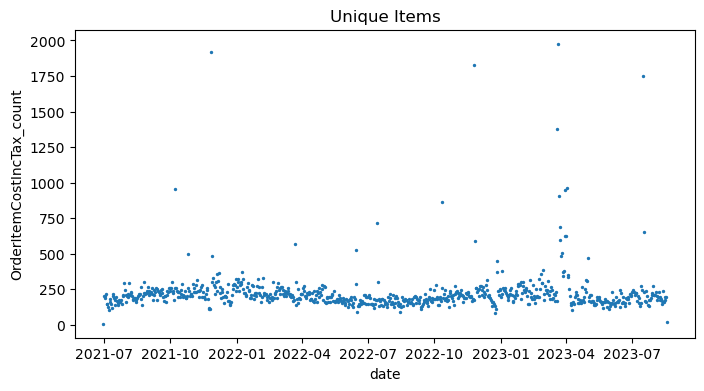

In [349]:
ts.reset_index().plot.scatter(x='date', y='OrderItemCostIncTax_count',figsize=(8,4),s=2)
plt.title('Unique Items')

Text(0.5, 1.0, 'Unique Customers')

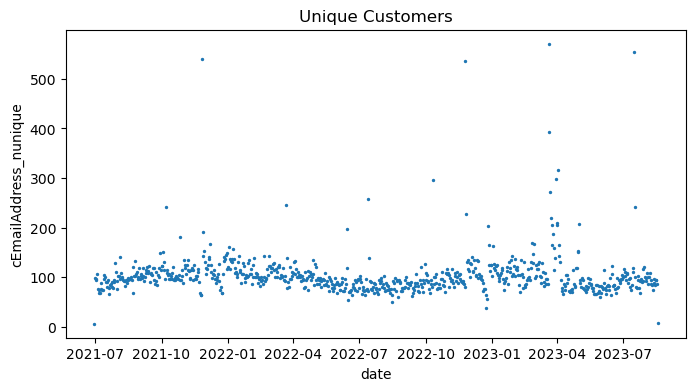

In [350]:
ts.reset_index().plot.scatter(x='date', y='cEmailAddress_nunique',figsize=(8,4),s=2)
plt.title('Unique Customers')

<AxesSubplot:title={'center':'Sales by month'}, xlabel='month'>

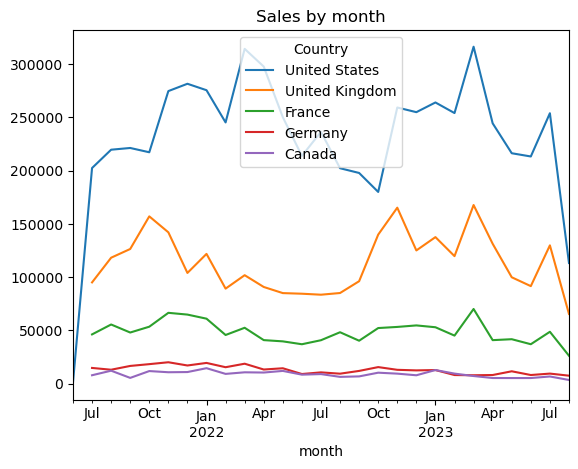

In [351]:
months = clean.groupby(['month','Country'])[revenue_col].sum().unstack()[top_countries]
months.plot(title='Sales by month')

<AxesSubplot:title={'center':'Sales by weekday'}, xlabel='weekday'>

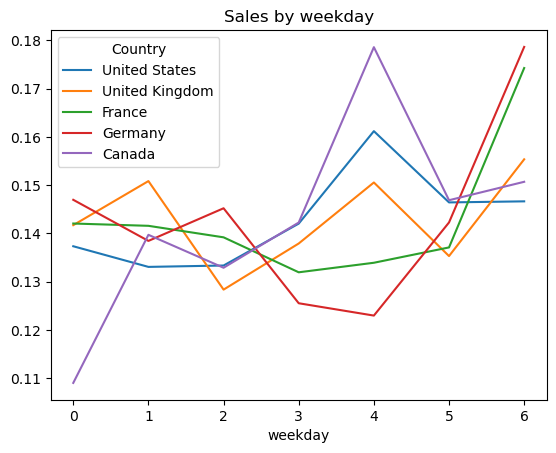

In [352]:
clean['weekday'] = clean[date_col].dt.weekday

weekdays = clean.groupby(['weekday','Country'])[revenue_col].sum().unstack()[top_countries[:5]]
weekdays = weekdays/weekdays.sum()
weekdays.plot(title='Sales by weekday')

<AxesSubplot:title={'center':'Sales by hour'}, xlabel='hour'>

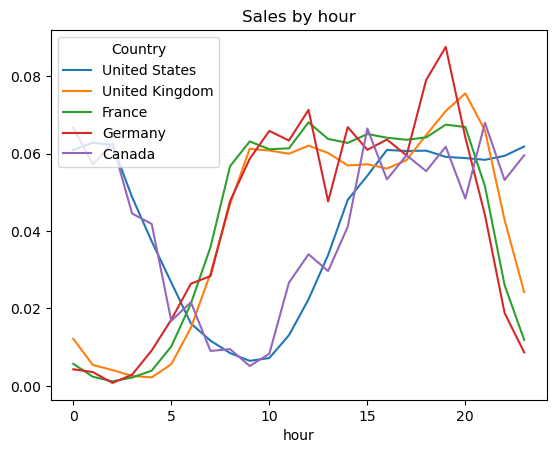

In [353]:
clean['hour'] = clean[date_col].dt.hour

hours = clean.groupby(['hour','Country'])[revenue_col].sum().unstack()[top_countries]
hours = hours/hours.sum()
hours.plot(title='Sales by hour')

### Compare the original and final (clean) datasets

In [354]:
def basic_stats(df,user_col,order_col,revenue_col):
    print(f'{(df.shape[0]/1000):.2f}k rows - {(df[user_col].nunique()/1000):.2f}k users - {(df[order_col].nunique()/1000):.2f}k orders - {(df[revenue_col].sum()/1000000):.3f}m revenue')
    
basic_stats(original,email_col,'nOrderId',revenue_col)
basic_stats(clean,email_col,'nOrderId',revenue_col)

195.87k rows - 55.90k users - 103.28k orders - 12.525m revenue
176.28k rows - 54.93k users - 90.66k orders - 11.805m revenue


In [355]:
# saving for later

clean.to_csv('clean.csv',index=False)

## Prepare an Order-level dataset

<AxesSubplot:xlabel='ItemCategory'>

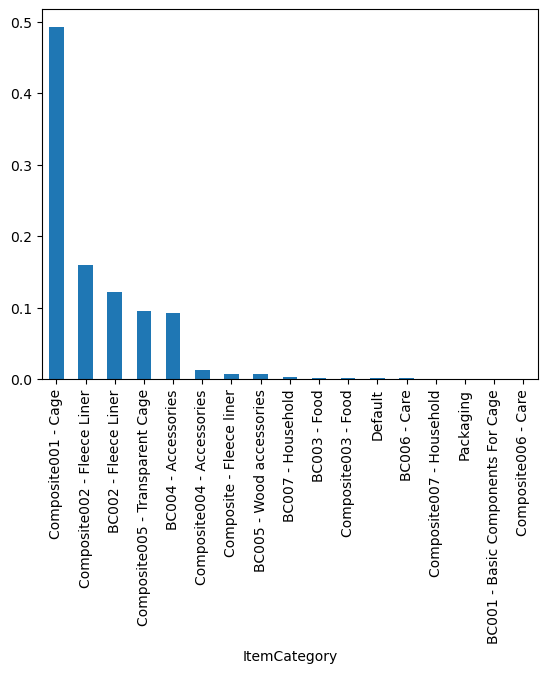

In [356]:
top_sellers = (clean.groupby(category_col)[revenue_col].sum().sort_values(ascending=False)/clean[revenue_col].sum())
top_sellers.plot.bar('Top revenue earners')

In [357]:
aliases = dict(zip(top_sellers.index,
                  ['C001Cage','C002Fleece','BC002Fleece','C005TCage','BC004Acc','C004Acc','CFleece','BC005WoodAcc','BC007House','BC003Food','C003Food','Default','BC006Care',
                  'C007House','Pack','BC001Basic','C006Care']))
clean['cat_alias'] = clean[category_col].replace(aliases)
clean

,nOrderId,ReferenceNum,ExternalReference,ChannelReference,Company,cFullName,cEmailAddress,cPostCode,dReceievedDate,Country,...,BuyerPhoneNumber,date,month,date_lag,exchange_rate,cost,revenue,weekday,hour,cat_alias
0,222899,5313330970855,36421,36421UK,NaN,Courtney Marshall,courtneyannexx@hotmail.com,DE7 6GE,2023-05-26 12:28:02,United Kingdom,...,07949 424073,2023-05-26,2023-05-01,4,1.00,31.4400,113.0000,4,12,C001Cage
1,230604,5371053670631,37780,37780UK,NaN,Julia Nems,juliaroksananems@outlook.com,9500,2023-07-08 14:18:08,Denmark,...,50 32 56 15,2023-07-08,2023-07-01,2,1.00,15.1600,88.0000,5,14,C002Fleece
2,211058,5198583234791,32566,32566UK,NaN,Eleanor Davies,ellyd_503@hotmail.com,N12 8JG,2023-03-06 14:00:04,United Kingdom,...,07952 787991,2023-03-06,2023-03-01,1,1.00,9.0000,67.0000,0,14,C002Fleece
3,211058,5198583234791,32566,32566UK,NaN,Eleanor Davies,ellyd_503@hotmail.com,N12 8JG,2023-03-06 14:00:04,United Kingdom,...,07952 787991,2023-03-06,2023-03-01,1,1.00,13.4400,75.0000,0,14,C002Fleece
4,147639,4589230293231,12681,#12681,NaN,ISABELLE MARGOT,layssa74@yahoo.fr,74160,2021-11-29 10:05:23,France,...,+33782772648,2021-11-29,2021-11-01,5,0.85,8.2450,48.4500,0,10,C002Fleece
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195860,221491,5243643297962,35702,35702USA,NaN,Mehrnaz Mehrzad,mehrnaz90@berkeley.edu,95624-4084,2023-05-12 05:50:05,United States,...,+19167417794,2023-05-12,2023-05-01,0,0.79,2.6070,33.1800,4,5,BC005WoodAcc
195861,221491,5243643297962,35702,35702USA,NaN,Mehrnaz Mehrzad,mehrnaz90@berkeley.edu,95624-4084,2023-05-12 05:50:05,United States,...,+19167417794,2023-05-12,2023-05-01,0,0.79,10.0014,93.2200,4,5,C002Fleece
195862,130244,3962467090626,10363,#10363,NaN,ISABELLE COTTA,placbat@wanadoo.fr,06000,2021-08-02 19:48:42,France,...,06 19 58 19 73,2021-08-02,2021-08-01,1,0.85,8.2450,44.2680,0,19,C002Fleece
195863,130244,3962467090626,10363,#10363,NaN,ISABELLE COTTA,placbat@wanadoo.fr,06000,2021-08-02 19:48:42,France,...,06 19 58 19 73,2021-08-02,2021-08-01,1,0.85,7.6500,47.4300,0,19,C002Fleece


In [359]:
clean.iloc[0]

nOrderId                                                            222899
ReferenceNum                                                 5313330970855
ExternalReference                                                    36421
ChannelReference                                                   36421UK
Company                                                                NaN
cFullName                                                Courtney Marshall
cEmailAddress                                   courtneyannexx@hotmail.com
cPostCode                                                          DE7 6GE
dReceievedDate                                         2023-05-26 12:28:02
Country                                                     United Kingdom
status                                                                PAID
Processed                                                             True
ProcessedDate                                          2023-05-30 14:11:52
Source                   

In [358]:
aliases

{'Composite001 - Cage': 'C001Cage',
 'Composite002 - Fleece Liner': 'C002Fleece',
 'BC002 - Fleece Liner': 'BC002Fleece',
 'Composite005 - Transparent Cage': 'C005TCage',
 'BC004 - Accessories': 'BC004Acc',
 'Composite004 - Accessories': 'C004Acc',
 'Composite - Fleece liner': 'CFleece',
 'BC005 - Wood accessories': 'BC005WoodAcc',
 'BC007 - Household': 'BC007House',
 'BC003 - Food': 'BC003Food',
 'Composite003 - Food': 'C003Food',
 'Default': 'Default',
 'BC006 - Care': 'BC006Care',
 'Composite007 - Household': 'C007House',
 'Packaging': 'Pack',
 'BC001 - Basic Components For Cage': 'BC001Basic',
 'Composite006 - Care': 'C006Care'}

In [390]:
orderid_col = 'nOrderId'
category_col = 'ItemCategory'

orders = clean.groupby([orderid_col,email_col,'date','month','Country','cPostCode']).agg({revenue_col:['sum','count'],'cat_alias':' '.join})
orders.reset_index(inplace=True)
orders.columns = 'orderId email date month country postcode order_spend n_items items'.split()
orders.head()

,orderId,email,date,month,country,postcode,order_spend,n_items,items
0,126519,karadishman10@gmail.com,2021-06-30,2021-06-01,United States,46582,135.0,1,C001Cage
1,126520,amandalittleton@live.com,2021-06-30,2021-06-01,United States,29466,150.0,1,C001Cage
2,126521,danne.arellano@gmail.com,2021-06-30,2021-06-01,United States,91710,70.0,1,C001Cage
3,126522,kevinagareau23@gmail.com,2021-06-30,2021-06-01,United States,34637,162.0,3,C002Fleece BC002Fleece BC004Acc
4,126523,deleonm949@gmail.com,2021-06-30,2021-06-01,United States,92688,205.0,1,C001Cage


<AxesSubplot:title={'center':'A material fraction of clients place 2+ orders on the same day\nShould they be considered as one order for customer analysis?'}>

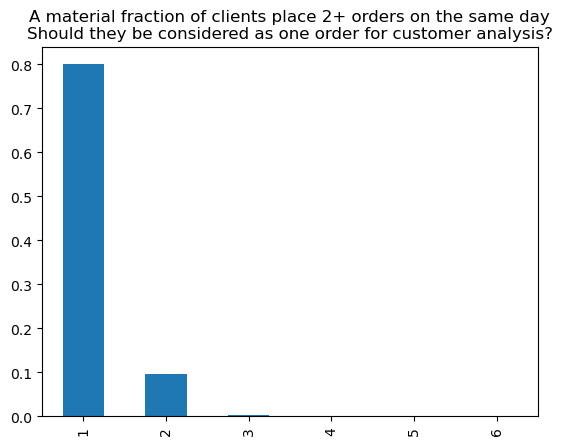

In [391]:
(orders.groupby(['email','date'])['orderId'].nunique().value_counts()/orders.shape[0]).plot.bar(title='A material fraction of clients place 2+ orders on the same day\nShould they be considered as one order for customer analysis?')

In [392]:
orders.shape

(90597, 9)

In [393]:
orders = orders.groupby(['email','date']).agg({'orderId':list,'month':'min','country':'min','postcode':'min','order_spend':'sum','n_items':'sum','items':' '.join}).reset_index()
orders['orderId'] = orders['orderId'].apply(lambda l: '_'.join(map(str,l)))
orders.head()

,email,date,orderId,month,country,postcode,order_spend,n_items,items
0,007jaybee007@gmail.com,2023-04-02,216515,2023-04-01,United Kingdom,NG19 0NT,132.40,3,C001Cage C001Cage BC004Acc
1,008876a2656e8c6e7ffd@members.ebay.com,2021-07-15,128056,2021-07-01,Ireland,E91 KP44,42.93,1,C001Cage
2,0090d363c15630a912b7@members.ebay.com,2021-10-24,141960,2021-10-01,Netherlands,2023 AA,47.93,1,C001Cage
3,0091d59989509abd2536@members.ebay.com,2021-11-05,143783,2021-11-01,United Kingdom,S20 1AS,47.93,1,C001Cage
4,01010010.preci@gmail.com,2023-06-18,226268,2023-06-01,United States,80112,120.70,1,C005TCage


In [394]:
orders.shape

(81371, 9)

In [395]:
orders['order_number'] = 1

temp = []

def process_customer_ts(df):
    df = df.set_index('orderId')
    df['order_number'] = df['order_number'].cumsum()
    df['LTV_so_far'] = df['order_spend'].cumsum()
    df['days_since_last_order'] = ((df['date'] - df['date'].shift()).fillna(np.timedelta64(0,'D'))/np.timedelta64(1,'D')).astype(int)
    df['everything_bought_before'] = (df['items']+' + ').shift().fillna('').cumsum().apply(lambda t: t[:-3])
    df['date_joined'] = df['date'].min()
    df['days_since_joined'] = ((df['date'] - df['date_joined']) / np.timedelta64(1,'D')).astype(int)
    df['aov_so_far'] = df['LTV_so_far'] / df['order_number']
    temp.append(df)

gb = orders.groupby('email')

for _,df in tqdm(gb):
    process_customer_ts(df)

orders = pd.concat(temp,axis=0)

  0%|          | 0/54901 [00:00<?, ?it/s]

In [424]:
orders.reset_index(inplace=True)

In [425]:
orders[orders['everything_bought_before'].str.len()>2000]

,orderId,email,date,month,country,postcode,order_spend,n_items,items,order_number,LTV_so_far,days_since_last_order,everything_bought_before,date_joined,days_since_joined,aov_so_far,cluster,cluster_name
35039,176169,info@piglo.net,2022-06-08,2022-06-01,Finland,20780,39.9,1,C001Cage,118,12735.1,5,C001Cage C001Cage + C001Cage C001Cage + C001Ca...,2021-07-01,342,107.924576,2,habitual high
35040,176168,info@piglo.net,2022-06-09,2022-06-01,Finland,2180,39.9,1,C001Cage,119,12775.0,1,C001Cage C001Cage + C001Cage C001Cage + C001Ca...,2021-07-01,343,107.352941,2,habitual high
35041,176167,info@piglo.net,2022-06-11,2022-06-01,Finland,1350,86.1,1,C001Cage,120,12861.1,2,C001Cage C001Cage + C001Cage C001Cage + C001Ca...,2021-07-01,345,107.175833,2,habitual high
35042,176166,info@piglo.net,2022-06-12,2022-06-01,Finland,40100,73.5,1,C001Cage,121,12934.6,1,C001Cage C001Cage + C001Cage C001Cage + C001Ca...,2021-07-01,346,106.897521,2,habitual high
35043,176165_176175,info@piglo.net,2022-06-13,2022-06-01,Finland,37100,116.2,2,C001Cage C001Cage,122,13050.8,1,C001Cage C001Cage + C001Cage C001Cage + C001Ca...,2021-07-01,347,106.973770,2,habitual high
35044,178274_179373,info@piglo.net,2022-06-19,2022-06-01,Finland,01490,192.5,3,C001Cage C001Cage C001Cage,123,13243.3,6,C001Cage C001Cage + C001Cage C001Cage + C001Ca...,2021-07-01,353,107.669106,2,habitual high
35045,178277,info@piglo.net,2022-06-22,2022-06-01,Finland,20780,40.6,1,C001Cage,124,13283.9,3,C001Cage C001Cage + C001Cage C001Cage + C001Ca...,2021-07-01,356,107.128226,2,habitual high
35046,178279,info@piglo.net,2022-06-23,2022-06-01,Finland,28370,51.8,1,C001Cage,125,13335.7,1,C001Cage C001Cage + C001Cage C001Cage + C001Ca...,2021-07-01,357,106.685600,2,habitual high
35047,178276,info@piglo.net,2022-06-24,2022-06-01,Finland,09220,22.4,1,C001Cage,126,13358.1,1,C001Cage C001Cage + C001Cage C001Cage + C001Ca...,2021-07-01,358,106.016667,2,habitual high
35048,179372,info@piglo.net,2022-06-26,2022-06-01,Finland,980,71.4,1,C001Cage,127,13429.5,2,C001Cage C001Cage + C001Cage C001Cage + C001Ca...,2021-07-01,360,105.744094,2,habitual high


In [426]:
piglo = orders[orders['email'] == 'info@piglo.net']
piglo['LTV_so_far']

34922      107.1
34923      239.4
34924      273.7
34925      396.2
34926      551.6
          ...   
35045    13283.9
35046    13335.7
35047    13358.1
35048    13429.5
35049    13540.1
Name: LTV_so_far, Length: 128, dtype: float64

In [397]:
# date_joined = orders.groupby('email')['date'].min()
# orders['date_joined'] = orders['email'].replace(date_joined.to_dict())

In [398]:
# orders['days_since_joined'] = ((orders['date'] - orders['date_joined']) / np.timedelta64(1,'D')).astype(int)

In [399]:
# orders['aov_so_far'] = orders['LTV_so_far'] / orders['order_number']

In [427]:
# saving for later

orders.to_csv('orders.csv',index=False)

In [428]:
orders.columns

Index(['orderId', 'email', 'date', 'month', 'country', 'postcode',
       'order_spend', 'n_items', 'items', 'order_number', 'LTV_so_far',
       'days_since_last_order', 'everything_bought_before', 'date_joined',
       'days_since_joined', 'aov_so_far', 'cluster', 'cluster_name'],
      dtype='object')

,mean,min,max,perc_16,perc_50,perc_84
month,,,,,,
2021-06-01,135.333333,70.0,205.0,86.000,142.5,170.6000
2021-07-01,142.336009,3.0,1230.0,59.256,120.0,225.0000
2021-08-01,144.833300,2.0,1350.0,60.000,116.0,237.0000
2021-09-01,142.499879,5.0,1040.0,60.000,115.0,232.0400
2021-10-01,143.243238,2.0,1068.0,60.000,113.0,227.9328


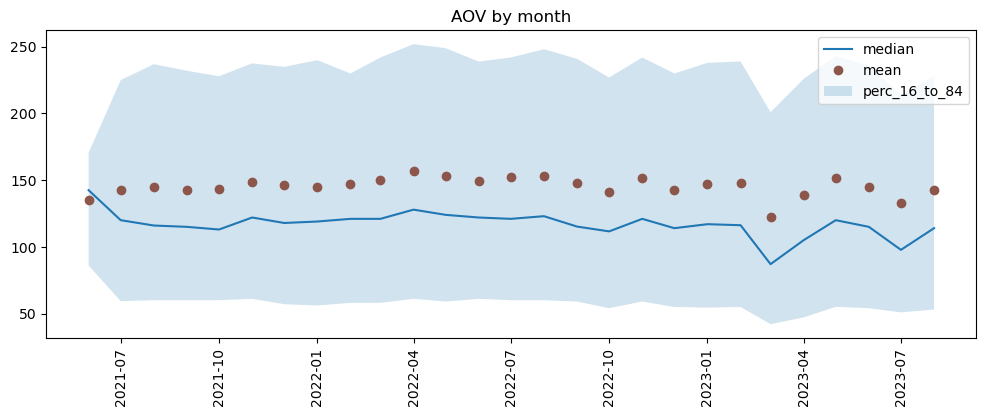

In [429]:
aov = plot_bands(orders,'month','order_spend','AOV by month')
aov.head()

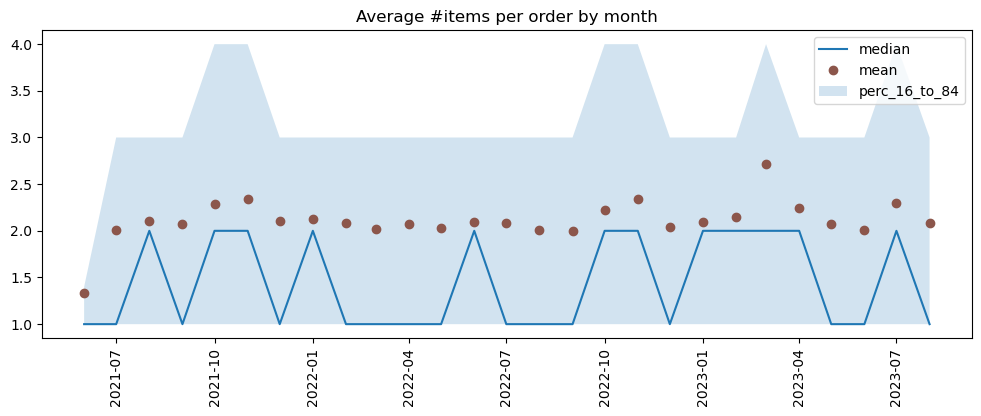

In [403]:
n_items = plot_bands(orders,'month','n_items','Average #items per order by month')

### Big Spenders

In [430]:
orders.sort_values('order_spend',ascending=False)[:10]

,orderId,email,date,month,country,postcode,order_spend,n_items,items,order_number,LTV_so_far,days_since_last_order,everything_bought_before,date_joined,days_since_joined,aov_so_far,cluster,cluster_name
76267,213614_213615_215197_215198,theflyingheeler@gmail.com,2023-03-21,2023-03-01,United States,72719,3248.3,31,C001Cage C001Cage BC004Acc BC004Acc BC004Acc C...,2,4353.30,17,C001Cage BC004Acc BC004Acc C005TCage BC004Acc ...,2023-03-04,17,2176.65,3,fresh returning high
17566,184165_184251_184252_184253_184254_184255,chamispourlavie@gmail.com,2022-08-21,2022-08-01,France,83140,1985.4,18,C001Cage BC002Fleece C001Cage C001Cage C001Cag...,2,2079.40,196,C001Cage C001Cage,2022-02-06,196,1039.70,1,lapsed returning
74711,209794_209795_209850_209881,sutterinc73@gmail.com,2023-02-27,2023-02-01,United States,01913,1883.1,19,C001Cage C002Fleece C002Fleece C002Fleece C002...,3,2569.08,1,BC004Acc BC004Acc C002Fleece BC004Acc C002Flee...,2022-10-18,132,856.36,2,habitual high
79262,149579_149867_149868_149869_149870_149871,virginie.foures31@gmail.com,2021-12-09,2021-12-01,France,31600,1817.0,7,C002Fleece C001Cage C001Cage C002Fleece CFleec...,1,1817.00,0,,2021-12-09,0,1817.00,4,newbie high
49063,179477_179497,lhr@lhreporting.com,2022-07-13,2022-07-01,United States,11560,1781.9,10,BC002Fleece BC004Acc BC004Acc BC004Acc BC002Fl...,1,1781.90,0,,2022-07-13,0,1781.90,4,newbie high
72960,171151,sophiegloor@citycable.ch,2022-05-02,2022-05-01,Switzerland,1073,1732.9,40,BC004Acc BC004Acc BC004Acc BC004Acc BC004Acc C...,1,1732.90,0,,2022-05-02,0,1732.90,4,newbie high
10095,151652_152079_152080,apatheticpersona@gmail.com,2021-12-24,2021-12-01,United States,95667,1670.0,15,BC004Acc BC004Acc C001Cage C001Cage BC004Acc C...,1,1670.00,0,,2021-12-24,0,1670.00,4,newbie high
66597,202456_202561_202562,rmeacham1@gmail.com,2023-01-05,2023-01-01,United States,85650,1556.0,9,C005TCage C002Fleece C005TCage BC005WoodAcc C0...,1,1556.00,0,,2023-01-05,0,1556.00,4,newbie high
6066,170064_170103_170499,alexanderfamily_6@yahoo.com,2022-04-24,2022-04-01,United States,97322,1542.0,27,C001Cage BC002Fleece BC004Acc BC004Acc BC002Fl...,1,1542.00,0,,2022-04-24,0,1542.00,4,newbie high
10096,157971_158104_158317,apatheticpersona@gmail.com,2022-01-31,2022-01-01,United States,95667,1496.0,7,BC004Acc BC004Acc BC004Acc BC004Acc C002Fleece...,2,3166.00,38,BC004Acc BC004Acc C001Cage C001Cage BC004Acc C...,2021-12-24,38,1583.00,2,habitual high


## Now we can build a simple categorisation of customers, based on RFM

- Recency : when did they last order?           ---> days_since_last_order
- Frequency : how often do they order?          ---> order_number
- Monetary : how much did they spend in total?  ---> LTV_so_far
- AOV : how much do they spend on average       ---> aov_so_far

## Potentially interesting to later also look at

- Loyalty : which month did they first join?    ---> days_since_joined
- Items : what did they buy?                    ---> items, everything_bought_so_far

In [404]:
from sklearn.cluster import MeanShift, KMeans, DBSCAN, AffinityPropagation
from sklearn.preprocessing import RobustScaler,StandardScaler

import pickle

In [406]:

clustering_cols = 'days_since_last_order order_number LTV_so_far aov_so_far days_since_joined'.split()

def create_clustering_data(orders):
    X = orders[clustering_cols].copy()

    X['LTV_so_far'] = np.log(X['LTV_so_far'])
    X['aov_so_far'] = np.log(X['aov_so_far'])

    X['days_since_joined'] = np.log(X['days_since_joined'] + 1)
    X['days_since_last_order'] = np.log(X['days_since_last_order'] + 1)
    X['days_since_last_order'] = X['days_since_last_order'].apply(lambda x: 10 if x == 0 else x) # a value of 0 means it is a first order (assuming eq to a very long lapsed cust.)

    X['order_number'] = X['order_number']**0.5
    return X

X = create_clustering_data(orders)


In [355]:

# cluster = KMeans(n_clusters=5)

# labels = cluster.fit_predict(X.values)



# with open('cluster_model.pickle','wb') as file:
#     pickle.dump(cluster,file)

In [407]:
with open('cluster_model.pickle','rb') as file:
    cluster = pickle.load(file)
    
labels = cluster.predict(X.values)

In [408]:
pd.Series(labels).value_counts()

4    31630
0    23271
1    10085
2     9473
3     6912
dtype: int64

In [409]:
orders['cluster'] = labels

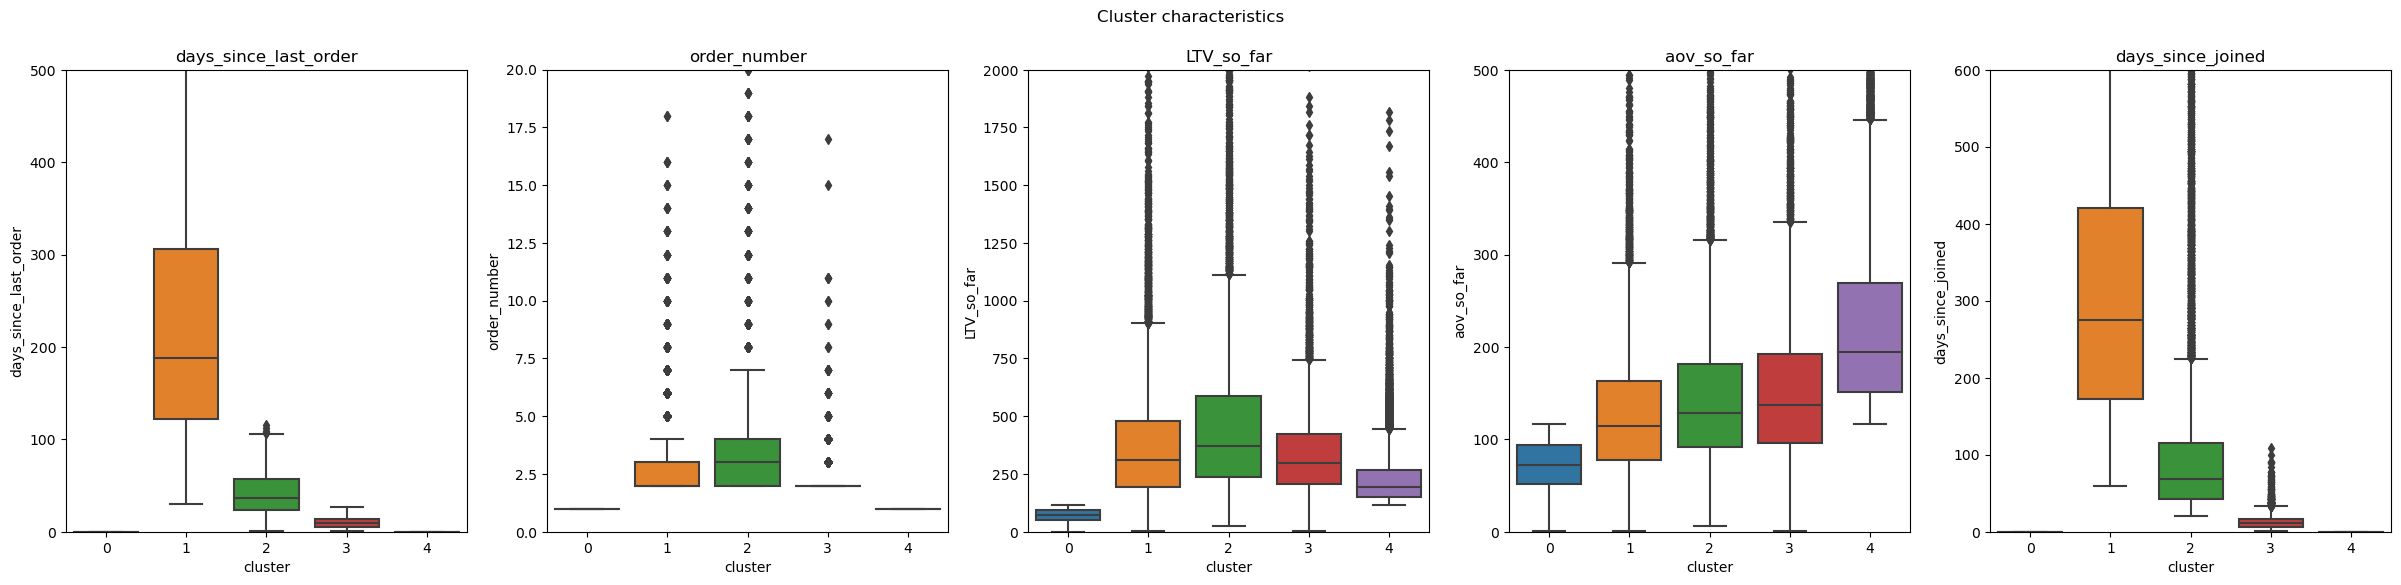

In [410]:
fig, axes = plt.subplots(nrows=1,ncols=len(clustering_cols),figsize=(30,6))
fig.suptitle('Cluster characteristics')
maximums = [500,20,2000,500,600]
for (col,ax,cap) in zip(clustering_cols,axes,maximums):
    
    sns.boxplot(data=orders,x='cluster',y=col,ax=ax)
    ax.set_title(col)
    ax.set_ylim(0,cap)
                    


In [411]:
names = {0: 'newbie low',           # new customer, low spend
         1: 'lapsed returning',     # older cohort, infrequent large orders
         2: 'habitual high',        # recent customer, frequent large orders
         3: 'fresh returning high', # very recent new customer, high spender
         4: 'newbie high'           # new customer, very high spend
        }

Low : less than 100
Medium : less than 200
High : more than 200

Newbie : 1st order
Returning : less than 10 days ago
Habitual : less than 6 months ago
Lapsed : more than 6 months ago

# Loyal : more than 5 orders
# Whale : more than 500 LTV

In [694]:
orders['Recency_cat'] = orders.apply(lambda row: 'Newbie' if row['order_number'] == 1 else ('ForgotSomething' if row['days_since_last_order'] <= 10 else ('Less6Months' if row['days_since_last_order'] <= 180 else 'Lapsed')),axis=1)
orders['AOV_cat'] = orders.apply(lambda row: ' £' if row['order_spend'] < 100 else (' ££' if row['order_spend'] < 200 else ' £££'),axis=1)
orders['Loyalty_cat'] = '' #orders['order_number'].apply(lambda x: 'Loyal' if x > 5 else '')

forgot_something_mask = orders['Recency_cat'] == 'ForgotSomething'
orders.loc[forgot_something_mask,'AOV_cat'] = ''

whale_mask = orders['LTV_so_far'] > 500
orders['Whale_cat'] = ''
orders.loc[whale_mask,'Whale_cat'] = 'Whale'
orders.loc[whale_mask,'AOV_cat'] = ''

In [692]:
for col in 'Recency_cat AOV_cat Loyalty_cat Whale_cat'.split():
    display(orders[col].value_counts())

Newbie             54934
6MonthsAgo         16125
Lapsed              5279
ForgotSomething     5084
Name: Recency_cat, dtype: int64

 £      30330
 ££     24764
 £££    15145
        11183
Name: AOV_cat, dtype: int64

    81422
Name: Loyalty_cat, dtype: int64

         73920
Whale     7502
Name: Whale_cat, dtype: int64

In [700]:
orders['segment'] = orders['Whale_cat']+orders['Recency_cat'] + orders['AOV_cat']
orders['segment'].value_counts()

Newbie ££               20430
Newbie £                19217
Newbie £££              14340
Less6Months £            8230
WhaleLess6Months         4152
ForgotSomething          3681
Less6Months ££           3172
Lapsed £                 2883
WhaleForgotSomething     1403
Lapsed ££                1162
WhaleLapsed              1000
WhaleNewbie               947
Less6Months £££           571
Lapsed £££                234
Name: segment, dtype: int64

In [715]:
segments = orders['segment'].unique()

In [716]:
colors = ["#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
        "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
        "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
        "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
        "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
        "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
        "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
        "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
        
        "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
        "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
        "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
        "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
        "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
        "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800",
        "#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51",
        "#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58"]


In [718]:
print('\n'.join([f'"{segment}": "{color}",' for segment,color in zip(segments,np.random.choice(colors,len(segments),replace=False))]))


"Newbie ££": "#000035",
"Newbie £": "#7A4900",
"ForgotSomething": "#4A3B53",
"Newbie £££": "#300018",
"Less6Months £": "#B77B68",
"WhaleNewbie": "#72418F",
"Less6Months ££": "#3B9700",
"Lapsed £": "#8FB0FF",
"Lapsed ££": "#FF90C9",
"WhaleLess6Months": "#1E6E00",
"Less6Months £££": "#C8A1A1",
"Lapsed £££": "#B79762",
"WhaleForgotSomething": "#9B9700",
"WhaleLapsed": "#0AA6D8",


In [705]:
orders['cluster_name'] = orders['segment']

In [431]:
orders['cluster_name'] = orders['cluster'].replace(names)

In [432]:
orders.to_csv('orders_with_cluster_labels.csv',index=False)

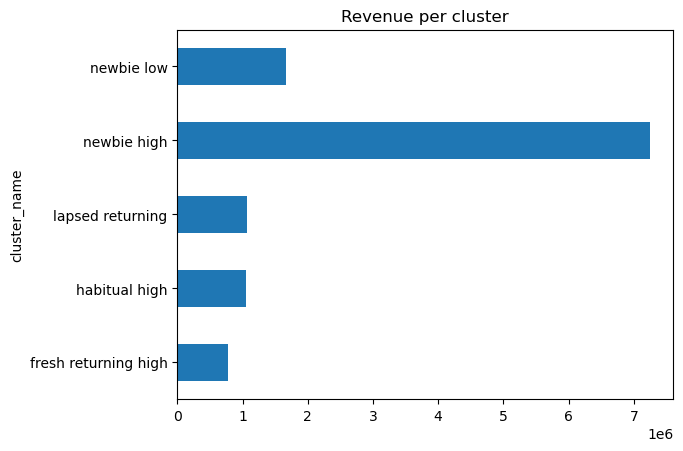

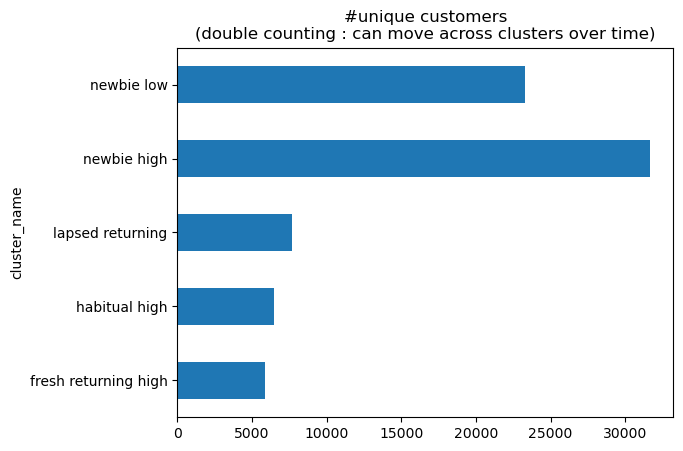

In [433]:
orders.groupby('cluster_name')['order_spend'].sum().plot.barh(title='Revenue per cluster')
plt.show()
orders.groupby('cluster_name')['email'].nunique().plot.barh(title='#unique customers\n(double counting : can move across clusters over time)')
plt.show()

<AxesSubplot:title={'center':'Revenue per cluster over time'}, xlabel='month'>

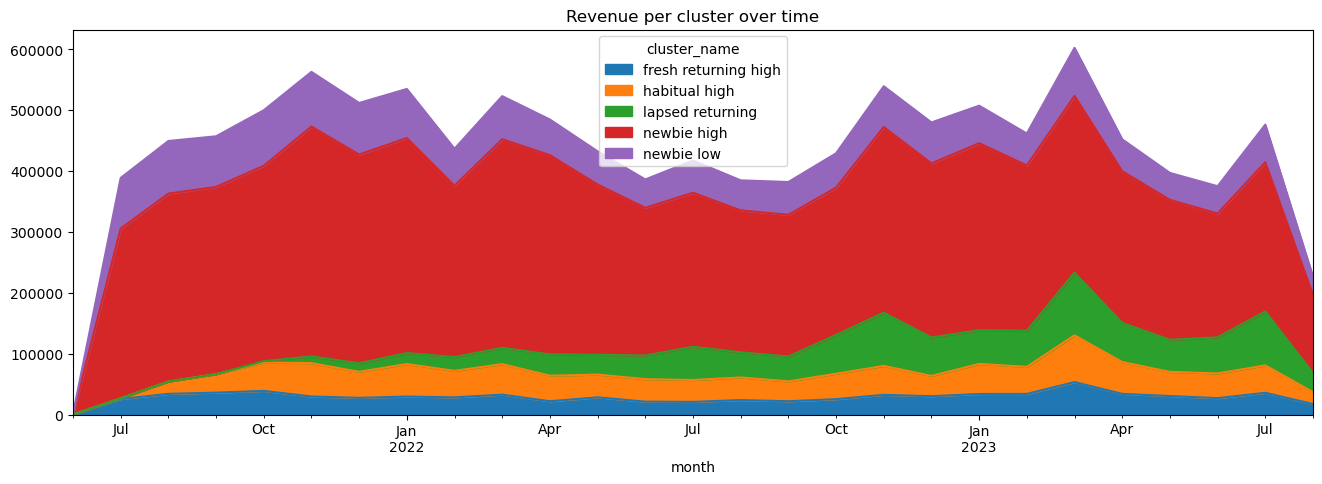

In [434]:
orders.groupby(['month','cluster_name'])['order_spend'].sum().unstack().plot.area(figsize=(16,5),title='Revenue per cluster over time')

In [435]:
cluster_summary = orders.groupby('cluster_name')[clustering_cols].mean()
cluster_summary

,days_since_last_order,order_number,LTV_so_far,aov_so_far,days_since_joined
cluster_name,,,,,
fresh returning high,9.759549,2.239728,347.286891,155.322762,12.041377
habitual high,40.788557,4.256519,603.081270,148.258153,109.252507
lapsed returning,230.051958,2.982647,382.263659,129.803872,308.688944
newbie high,0.000000,1.000000,228.930320,228.930320,0.000000
newbie low,0.000000,1.000000,71.460834,71.460834,0.000000


In [418]:
paths = []    
max_path_len = 8
_ = orders.groupby('email')['cluster_name'].progress_apply(lambda ts: paths.append('-'.join(ts.values[:max_path_len])+'-end'))
paths = pd.Series(paths).value_counts()
paths[:100]

  0%|          | 0/54901 [00:00<?, ?it/s]

newbie high-end                                                                                                                       21737
newbie low-end                                                                                                                        17655
newbie high-fresh returning high-end                                                                                                   2257
newbie high-lapsed returning-end                                                                                                       2151
newbie high-habitual high-end                                                                                                          1802
                                                                                                                                      ...  
newbie low-lapsed returning-habitual high-habitual high-lapsed returning-end                                                              6
newbie high-fresh re

In [419]:
import csv
min_freq = 0
path_csv = paths[paths>=min_freq]
pd.DataFrame(path_csv).to_csv('./sunburst/visit-sequences.csv',header=False,index=True,quoting=csv.QUOTE_NONE)

## Key Insights Questions

In [436]:
# Number of customers buying once / twice / 3 times / 4 times / 5 times or more in the last 9 months


cutoff_date = pd.to_datetime(orders['date'].max()) - np.timedelta64(9*30,'D')


mask = orders['date'] >= cutoff_date
last_9_months = remove(orders,mask,revenue_col='order_spend')

Removing 63.01% (51.3k from 81.4k rows), resulting in 64.11% revenue loss


In [437]:
orders.columns

Index(['orderId', 'email', 'date', 'month', 'country', 'postcode',
       'order_spend', 'n_items', 'items', 'order_number', 'LTV_so_far',
       'days_since_last_order', 'everything_bought_before', 'date_joined',
       'days_since_joined', 'aov_so_far', 'cluster', 'cluster_name'],
      dtype='object')

<AxesSubplot:title={'center':'Fraction of customers buying N times (over the last 9 months)'}>

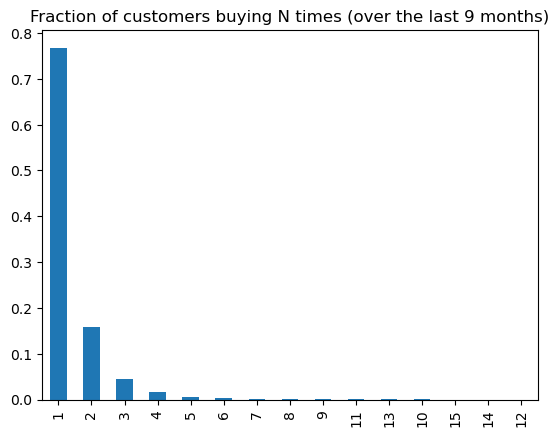

In [438]:
purchase_freq_9m = last_9_months.groupby('email')['orderId'].count().value_counts() / last_9_months['email'].nunique()
purchase_freq_9m.plot.bar(title='Fraction of customers buying N times (over the last 9 months)')

In [439]:
# Average time during order 1 then order 2 then order 3

last_9_months.groupby('order_number')['days_since_last_order'].agg(['mean',percentile(10),percentile(50),percentile(90)])[:5].astype(int)

,mean,perc_10,perc_50,perc_90
order_number,,,,
1,0,0,0,0
2,151,5,66,454
3,142,7,86,378
4,121,6,82,316
5,97,6,56,253


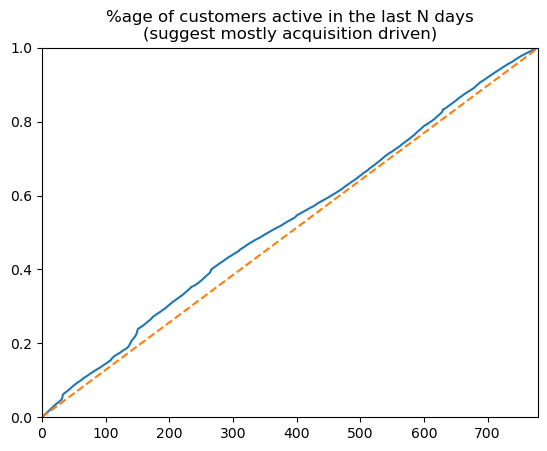

In [441]:
# % of segments of active customers : has purchased in the last 6 months / 6-12months / older than 12 months 

max_date = orders['date'].max()

def show_active(orders,title='%age of customers active in the last N days\n(suggest mostly acquisition driven)'):
    purchased_in_last_n_days = (max_date - orders.groupby('email')['date'].max()).value_counts()

    loyalty = (purchased_in_last_n_days.sort_index() / purchased_in_last_n_days.sum()).cumsum()
    loyalty.index = [x/np.timedelta64(1,'D') for x in loyalty.index]

    ax = loyalty.plot(title=title)
    ax.set_xlim(0,779)
    ax.set_ylim(0,1)
    plt.plot(np.linspace(0,len(loyalty),len(loyalty)),np.linspace(0,1,len(loyalty)),linestyle='dashed')
    plt.show()
    
show_active(orders)

In [442]:
# # same by cluster

# for cluster in orders['cluster_name'].unique():
#     show_active(orders[orders['cluster_name'] == cluster],title=cluster)

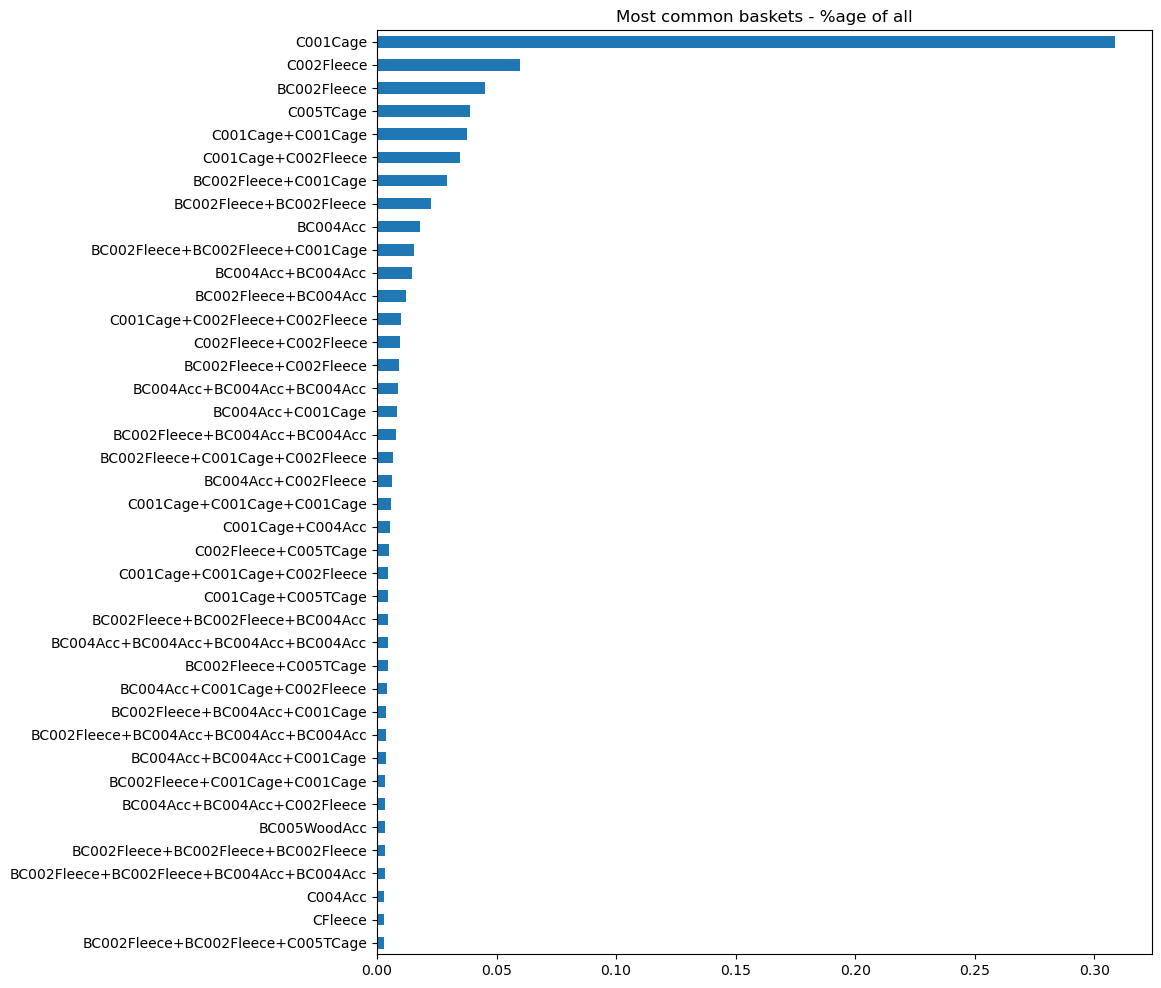

In [443]:
# What products is the average basket made up of?

most_common_baskets = orders['items'].apply(lambda x: '+'.join(sorted(x.split(' ')))).value_counts() / orders.shape[0]
ax = most_common_baskets[:40].sort_values(ascending=True).plot.barh(figsize=(10,12), title='Most common baskets - %age of all')


In [444]:
for prod in aliases.values():
    orders[f'has_{prod}'] = orders['items'].str.contains(prod)

Text(0.5, 1.0, 'Items co-occurence in orders')

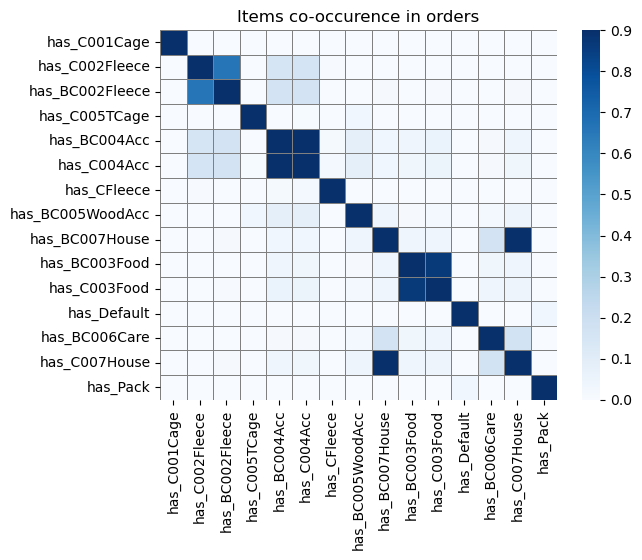

In [445]:
corr = orders[['has_C001Cage', 'has_C002Fleece',
       'has_BC002Fleece', 'has_C005TCage', 'has_BC004Acc', 'has_C004Acc',
       'has_CFleece', 'has_BC005WoodAcc', 'has_BC007House', 'has_BC003Food',
       'has_C003Food', 'has_Default', 'has_BC006Care', 'has_C007House',
       'has_Pack']].corr().clip(0,1)
mask = np.triu(np.ones_like(corr))
cmap = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(corr,cmap=cmap,vmax=0.9,linewidth=.5,linecolor='grey')
plt.title('Items co-occurence in orders')

17

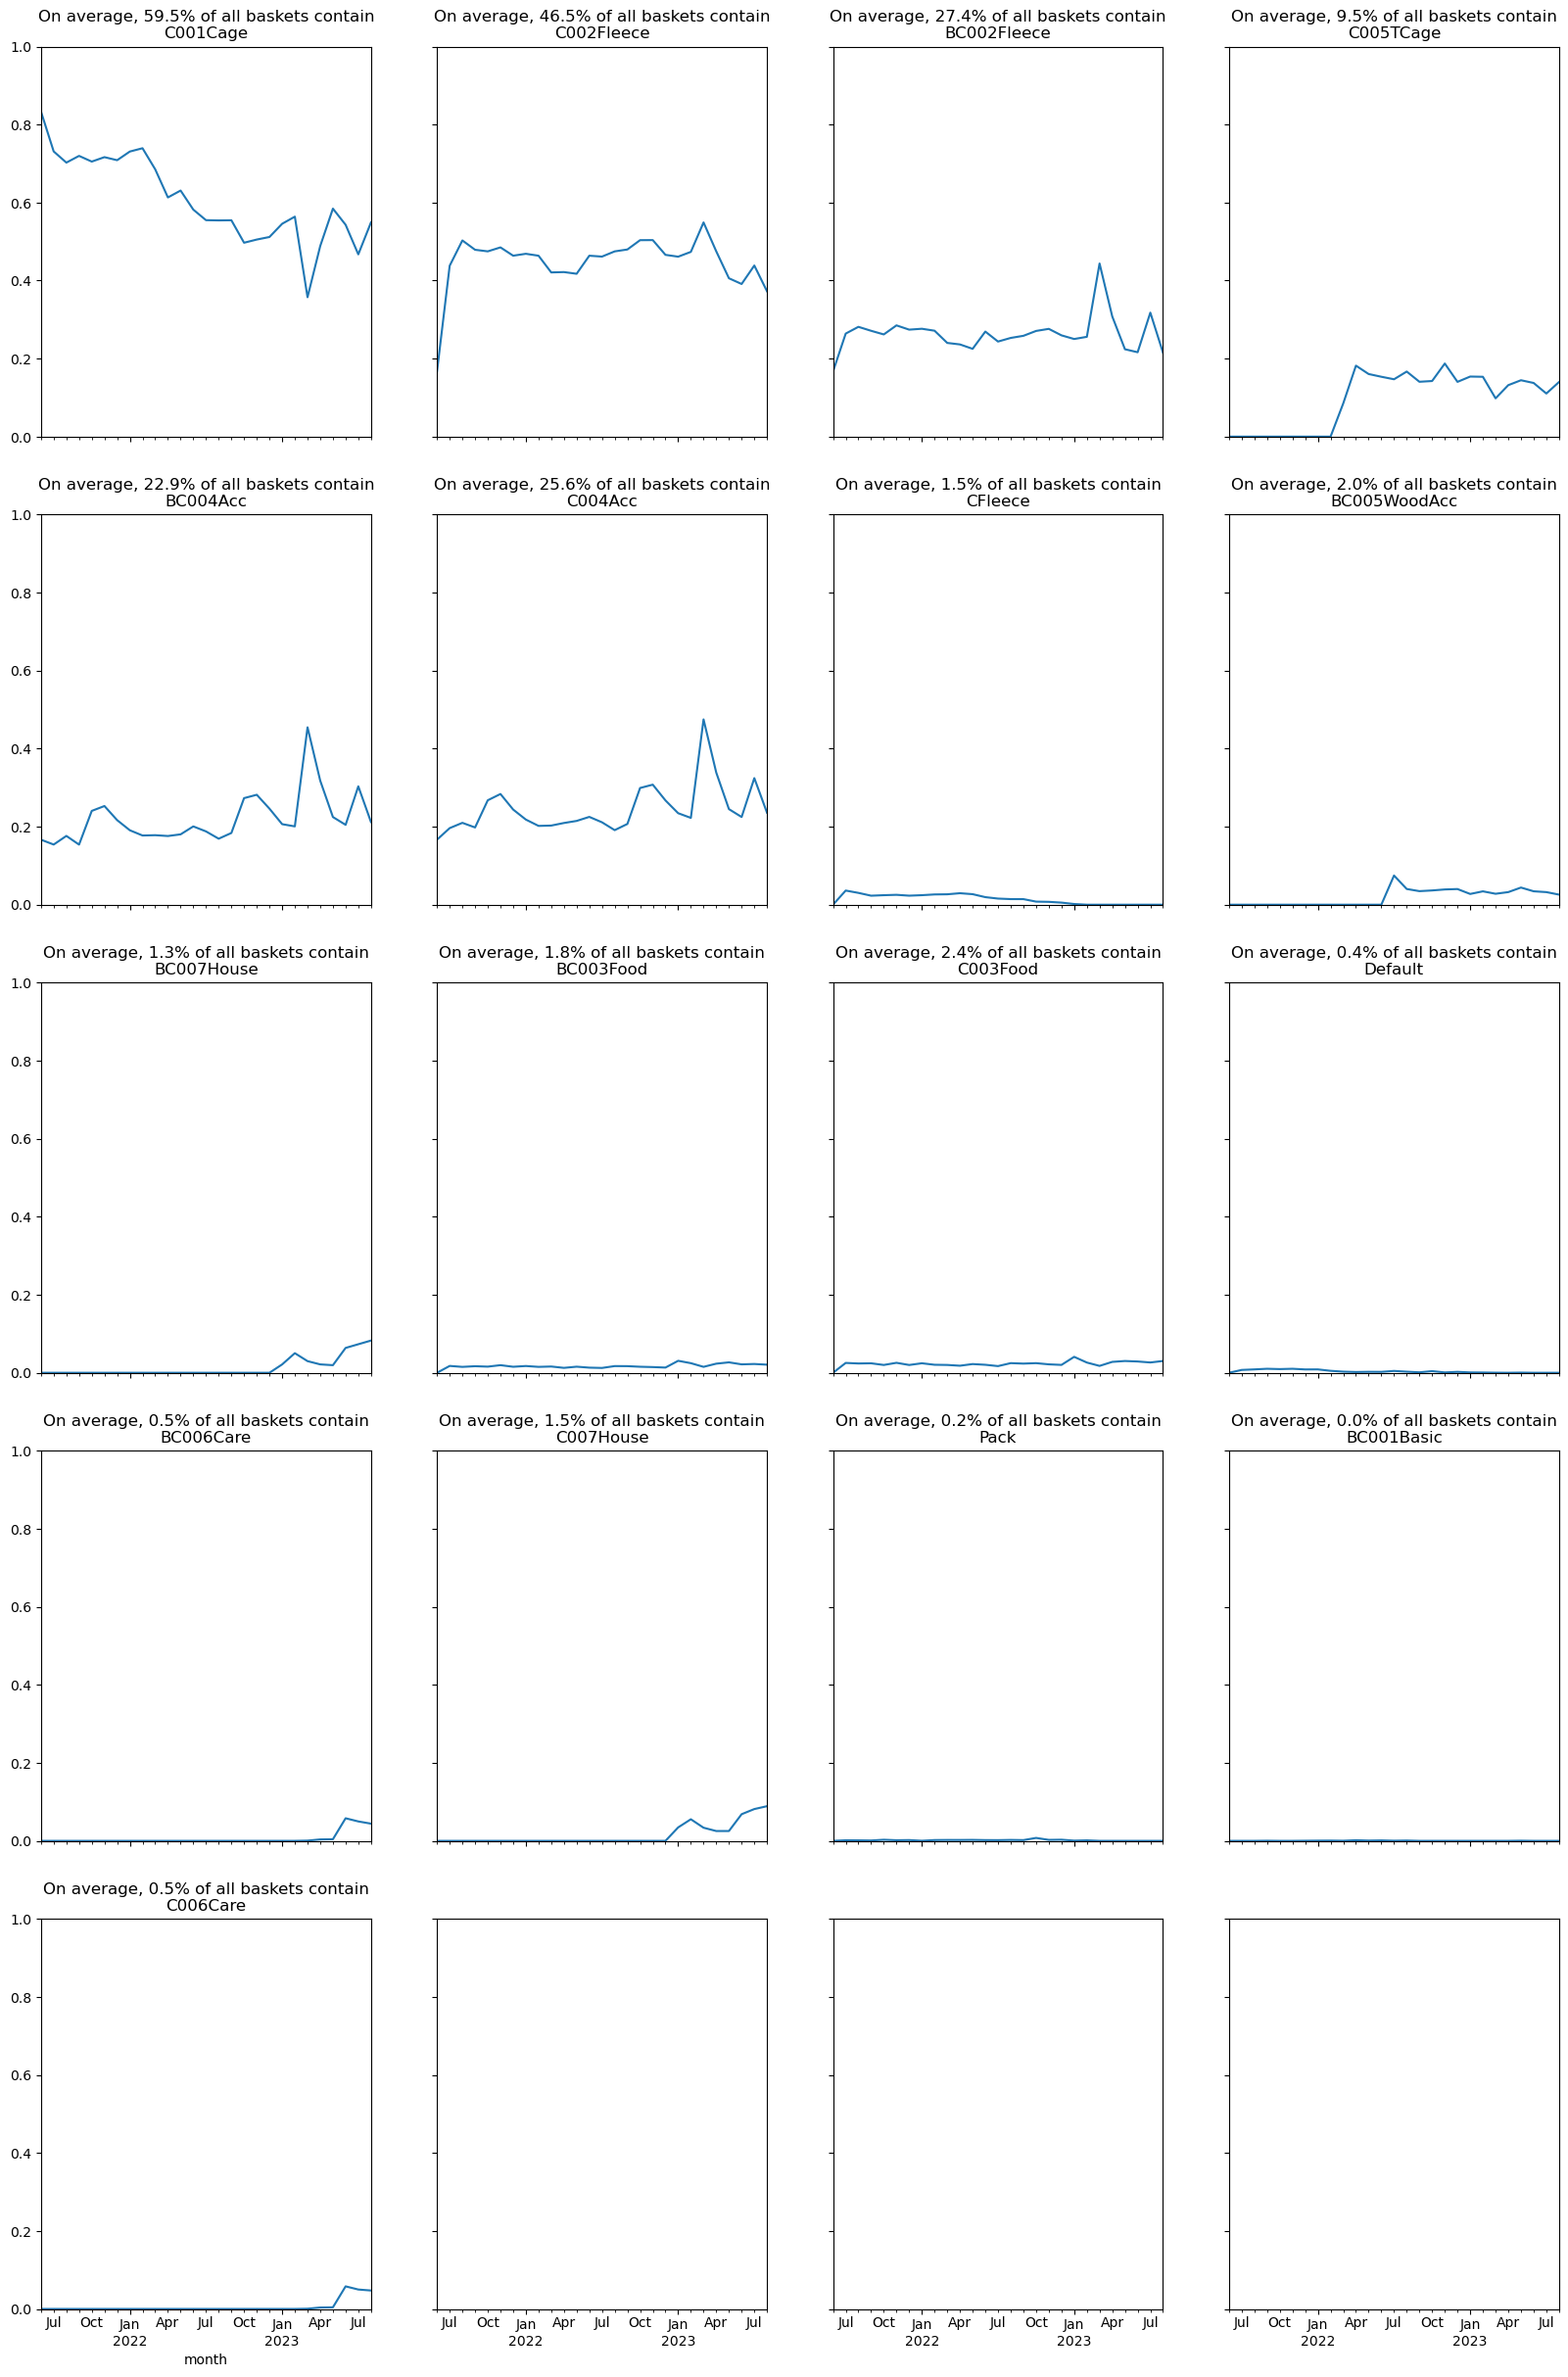

In [454]:
# contains product X
# X = ['C001Cage']

fig,axes = plt.subplots(nrows=5,ncols=4,figsize=(20,30),sharex=True,sharey=True)

def show_contain(X,ax=None):
    contains_X = orders.set_index('month')['items'].apply(lambda items: any(prod in items for prod in X))
    mean = contains_X.mean()
    if ax is None:
        ax = contains_X.reset_index().groupby('month')['items'].mean().plot(title='On average, ' + f'{(100*mean):.1f}%' + ' of all baskets contain\n'+' '.join(X))
    else:
        contains_X.reset_index().groupby('month')['items'].mean().plot(title='On average, ' + f'{(100*mean):.1f}%' + ' of all baskets contain\n'+' '.join(X), ax=ax)
    ax.set_ylim(0,1)

    
for prod,ax in zip(aliases.values(),axes.flatten()):
    show_contain([prod],ax=ax)

In [458]:
# # LTV

ltv = orders.groupby('email')['LTV_so_far'].max().sort_values(ascending=False)
# print(f'Average LTV :

Text(0.5, 1.0, 'LTV')

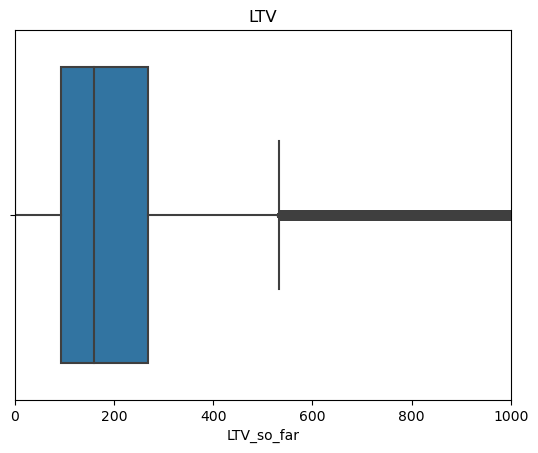

In [459]:
ax = sns.boxplot(ltv)
ax.set_xlim(0,1000)
plt.title('LTV')

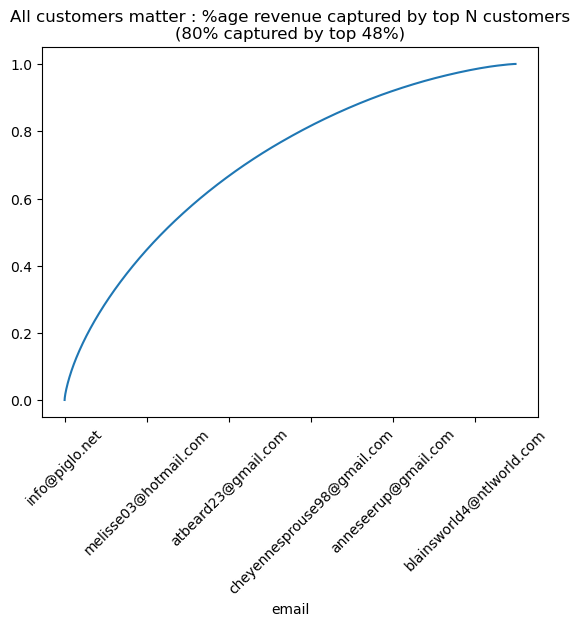

In [473]:
cumsum = (ltv.cumsum()/ltv.sum())

ax = cumsum.plot(title=f'All customers matter : %age revenue captured by top N customers\n(80% captured by top {(len(cumsum[cumsum>.8]) / cumsum.shape[0]*100):.0f}%)')
_ = plt.xticks(rotation=45)

<AxesSubplot:xlabel='month'>

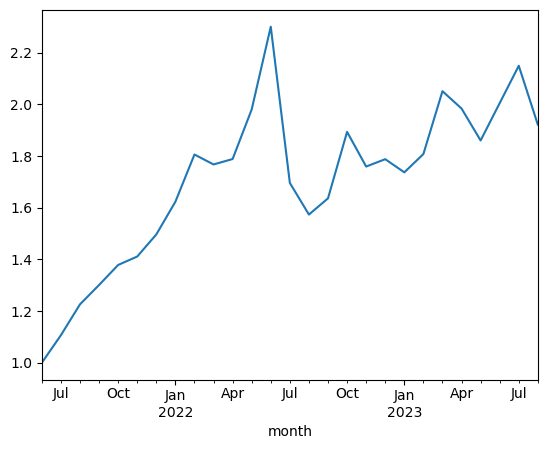

In [460]:
orders.groupby('month')['order_number'].mean().plot()

In [508]:
# rfm = orders.groupby('email').agg({'orderId':'count','date':['min','max'],'month':'min','order_spend':['sum','mean'],'n_items':'sum','items':','.join})
# rfm.columns = 'n_orders first_order_date last_order_date month_cohort total_spend aov n_items items'.split()

# rfm['frequency'] = 365/((rfm['last_order_date'] - rfm['first_order_date']) / np.timedelta64(1,'D') / rfm['n_orders'] + 1)
# mask = rfm['last_order_date'] == rfm['first_order_date']
# rfm.loc[mask,'frequency'] = 0.5

# max_date = rfm['last_order_date'].max()
# rfm['recency'] = ((max_date - rfm['last_order_date']) / np.timedelta64(1,'D')).astype(int)

# rfm.sort_values('total_spend',ascending=False,inplace=True)
# rfm.reset_index(inplace=True)
# rfm.to_csv('rfm.csv',index=False)

# display(rfm.head(10))
# display(rfm.tail(10))

In [ ]:
# # last purchased in last 6 months / more
# # purchased once / less than 5 times / more than 5
# # aov less than 100 / more
# # ordered every two months or more frequently

# rfm['active'] = rfm['recency'] < 183
# rfm['frequent'] = (rfm['purchase_frequency'] > 0) & (rfm['purchase_frequency'] <= 90)
# rfm['loyal'] = rfm['n_orders'].apply(lambda x: 'OneOff' if x == 1 else 'Loyal' if x >= 5 else 'Other')
# rfm['spender'] = rfm['aov'] > 200

# cluster_cols = 'active frequent loyal spender'.split()
# display(rfm.groupby(cluster_cols)[email_col].count().unstack([2,3]).fillna(0).astype(int))
# display((rfm.groupby(cluster_cols)['total_spend'].sum().unstack([2,3])/rfm['total_spend'].sum()*1000).fillna(0).astype(int)/10)

In [741]:
original.iloc[0]['OrderItemSKU OrderItemTitle'.split()].to_dict()

{'OrderItemSKU': 'A131SmallMeshWhite - Pistachio',
 'OrderItemTitle': '6x2 C&C cage L-Shape with small mesh white with divider&lid  - Pistachio'}

In [461]:
clean['margin'] = (clean['revenue'] - clean['cost']) / clean['revenue']
margins = clean.groupby('OrderItemSKU').agg({'revenue':'mean','margin':[percentile(10),percentile(50),percentile(90)]}).sort_values(('revenue','mean'),ascending=False)
prettify_columns(margins)
mask = margins['revenue_mean'] > 10
margins = remove(margins,mask,revenue_col='revenue_mean')
margins
# distinct_prices = original.groupby('OrderItemSKU')[revenue_col].nunique().sort_values()
# distinct_prices[distinct_prices>10]

Removing 1.76% (0.0k from 2.0k rows), resulting in 0.06% revenue loss


,revenue_mean,margin_perc_10,margin_perc_50,margin_perc_90
OrderItemSKU,,,,
A145SmallMeshBlack - Blue,326.270000,0.812906,0.812906,0.812906
A145SmallMeshWhite - Pistachio,312.050000,0.804380,0.804380,0.804380
A145SmallMeshWhite - Pink,312.050000,0.804380,0.804380,0.804380
A145SmallMeshWhite - Grey,308.134389,0.755281,0.804380,0.812906
A145SmallMeshBlack - Pistachio,304.981429,0.706509,0.768202,0.812906
...,...,...,...,...
UnscentedCageCleaner500,11.250400,0.791966,0.813467,0.842186
PB11-2Pillows-Leopard2,10.701050,0.843063,0.861176,0.942192
PB11-2Pillows-Strawberry,10.686373,0.836303,0.870718,0.932506


Text(0.5, 1.0, 'Median margins across all SKUs')

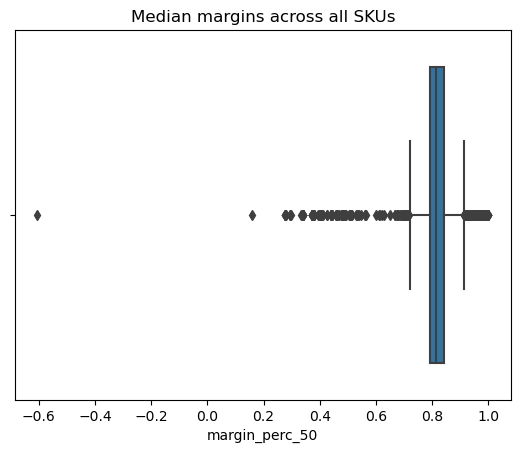

In [462]:
sns.boxplot(margins['margin_perc_50'])
plt.title('Median margins across all SKUs')

In [463]:
margins[margins['margin_perc_50']<0]

,revenue_mean,margin_perc_10,margin_perc_50,margin_perc_90
OrderItemSKU,,,,
A127V,14.325,-1.816914,-0.604571,0.607771


In [464]:
clean[clean['OrderItemSKU'] == 'A127V']['OrderItemTitle'].unique()

array(['1 Coroplast 4x2 Pistachio'], dtype=object)

Index(['LaundrybagSand', 'NibbleGuard10 - Clear', 'A083G', 'LaundrybagBlue',
       'A093G', 'A094SmallMeshBlack', 'A079B', 'A094SmallMeshWhite',
       'A079GuineaPig', 'A078GuineaPig',
       ...
       'A015SmallMeshWhite - Pink', 'FleeceLoft-Rainbow2', 'PB8-Sleep-Spots2',
       'A015SmallMeshWhite - Pistachio', 'PB4-Hammock-Christmas',
       'BinkyBarrier-3Pack', 'BoxCow6', 'BoxUnicorn3', 'A034SmallMeshWhite',
       'SetOf2-Fleece5x2-Leopard2'],
      dtype='object', length=769)

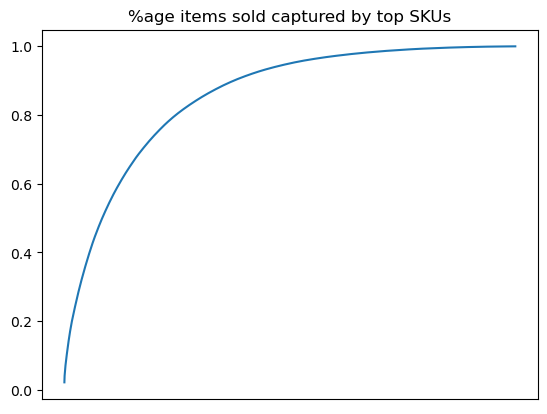

In [465]:
item_col = 'OrderItemSKU'

items_freq = (clean[item_col].value_counts() / clean.shape[0]).cumsum()
ax = items_freq.plot(title='%age items sold captured by top SKUs')
ax.set_xticks([])
top_skus = items_freq[items_freq < 0.9].index
top_skus

In [110]:
items_freq[items_freq < 0.9]

LaundrybagSand               0.021942
NibbleGuard10 - Clear        0.041024
A083G                        0.049386
LaundrybagBlue               0.057152
A093G                        0.064679
                               ...   
BinkyBarrier-3Pack           0.898670
BoxCow6                      0.898948
BoxUnicorn3                  0.899226
A034SmallMeshWhite           0.899498
SetOf2-Fleece5x2-Leopard2    0.899770
Name: OrderItemSKU, Length: 769, dtype: float64

In [475]:
basket_items = clean[clean[item_col].isin(top_skus)].groupby(email_col)[item_col].apply(set)
basket_items

cEmailAddress
007jaybee007@gmail.com                   {NibbleGuard10 - Clear, SetOf2-Correx5x2 - Gre...
008876a2656e8c6e7ffd@members.ebay.com                                              {A093G}
0090d363c15630a912b7@members.ebay.com                                              {A093P}
0091d59989509abd2536@members.ebay.com                                              {A093P}
0117bf7bafb733b49af3@members.ebay.com                                              {A093G}
                                                               ...                        
zyahgpenrice@gmail.com                                           {PB10-House-Cow, A074Cow}
zyahzpgpenrice06@gmail.com                              {WoodHayRack001, PB10-House-Grey2}
zyia.lind@gmail.com                                      {A075Unicorn, PB7-Haybag-Unicorn}
zymeth38@hotmail.com                                                               {A083G}
zzyyqq77@hotmail.com                     {A001SmallMeshWhite - Grey, A093G, 

In [476]:
item2cat['A083V']

'Composite001 - Cage'

In [477]:
cooccurences = pd.concat([basket_items.apply(lambda s: sku in s).rename(sku) for sku in tqdm(top_skus)], axis=1)

  0%|          | 0/769 [00:00<?, ?it/s]

In [478]:
cooccurences

,LaundrybagSand,NibbleGuard10 - Clear,A083G,LaundrybagBlue,A093G,A094SmallMeshBlack,A079B,A094SmallMeshWhite,A079GuineaPig,A078GuineaPig,...,A015SmallMeshWhite - Pink,FleeceLoft-Rainbow2,PB8-Sleep-Spots2,A015SmallMeshWhite - Pistachio,PB4-Hammock-Christmas,BinkyBarrier-3Pack,BoxCow6,BoxUnicorn3,A034SmallMeshWhite,SetOf2-Fleece5x2-Leopard2
cEmailAddress,,,,,,,,,,,,,,,,,,,,,
007jaybee007@gmail.com,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
008876a2656e8c6e7ffd@members.ebay.com,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0090d363c15630a912b7@members.ebay.com,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0091d59989509abd2536@members.ebay.com,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0117bf7bafb733b49af3@members.ebay.com,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zyahgpenrice@gmail.com,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
zyahzpgpenrice06@gmail.com,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
zyia.lind@gmail.com,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [479]:
def compute_jaccard(a,b):
    union = a | b
    intersection = a & b
    return intersection.sum()/union.sum()

jaccard = []
data = cooccurences.values
n = data.shape[1]
for i in tqdm(range(n)):
    a = data[:,i]
    row = []
    for j in range(i):
        b = data[:,j]
        row.append(compute_jaccard(a,b))
    row.extend([0]*(n-i))
    jaccard.append(row)
    
jaccard = pd.DataFrame(jaccard,index=top_skus,columns=top_skus)
has_data = jaccard.sum()
has_data = has_data[has_data > 0].index
has_data

  0%|          | 0/769 [00:00<?, ?it/s]

Index(['LaundrybagSand', 'NibbleGuard10 - Clear', 'A083G', 'LaundrybagBlue',
       'A093G', 'A094SmallMeshBlack', 'A079B', 'A094SmallMeshWhite',
       'A079GuineaPig', 'A078GuineaPig',
       ...
       'PB8-Sleep-Macachou', 'A004SmallMeshBlack - Grey',
       'A008SmallMeshBlack - Black', 'B023SmallMeshWhite - Grey',
       'A023SmallMeshBlack - Lilac', 'A024SmallMeshWhite - Lilac',
       'BunniesChaiseLongueBB', 'PB8-Sleep-Spots2', 'PB4-Hammock-Christmas',
       'BinkyBarrier-3Pack'],
      dtype='object', length=747)

In [256]:


# def sparse_corrcoef(A, B=None):

#     if B is not None:
#         A = sparse.vstack((A, B), format='csr')

#     A = A.astype(np.float64)
#     n = A.shape[1]

#     # Compute the covariance matrix
#     rowsum = A.sum(1)
#     centering = rowsum.dot(rowsum.T.conjugate()) / n
#     C = (A.dot(A.T.conjugate()) - centering) / (n - 1)

#     # The correlation coefficients are given by
#     # C_{i,j} / sqrt(C_{i} * C_{j})
#     d = np.diag(C)
#     coeffs = C / np.sqrt(np.outer(d, d))

#     return coeffs

In [257]:
# sparse_cooccurences = sparse.csr_matrix(cooccurences)
# sparse_cooccurences

In [258]:
# same_basket_corr = np.array(sparse_corrcoef(sparse_cooccurences.T))

In [480]:
min_corr = 0.05
data = jaccard + jaccard.T
mask = data>min_corr
same_basket_corr = np.where(mask,data,0)
mask.sum().sum()

2886

In [290]:
# [(x,item2cat[x]) for x in clean.groupby(item_col)[revenue_col].sum().sort_values(ascending=False)[:30].index]

In [291]:
# item2cat['A079GuineaPig']

In [481]:

data = pd.DataFrame(same_basket_corr,index=top_skus,columns=top_skus)
has_data = (data.sum() > 0)
has_data = has_data[has_data].index

data = data * np.tri(*same_basket_corr.shape,k=-1)
len(has_data)

479

In [482]:
groupsIds

{'Composite004 - Accessories': 0,
 'Packaging': 1,
 'BC005 - Wood accessories': 2,
 'BC002 - Fleece Liner': 3,
 'BC006 - Care': 4,
 'BC007 - Household': 5,
 'Composite - Fleece liner': 6,
 'Default': 7,
 'Composite002 - Fleece Liner': 8,
 'BC003 - Food': 9,
 'Composite006 - Care': 10,
 'Composite001 - Cage': 11,
 'Composite007 - Household': 12,
 'BC001 - Basic Components For Cage': 13,
 'BC004 - Accessories': 14,
 'Composite005 - Transparent Cage': 15,
 'Composite003 - Food': 16}

In [299]:
item2cat = clean.groupby(item_col)[category_col].apply(lambda ts: ts.value_counts().index[0]).to_dict()
groupsIds = set(item2cat.values())
groupsIds = dict(zip(groupsIds,range(len(groupsIds))))
ids = dict(zip(has_data,range(len(has_data))))

In [483]:
nodes = [{"name":sku, "id":id_, "group":groupsIds[item2cat[sku]]} for sku,id_ in ids.items()]
links = [{"source": ids[row], "target": ids[col], "value":int(np.ceil(100*data.loc[row,col]))}  for row in data.index for col in data.columns if data.loc[row,col] > 0]


In [484]:
import json
graph = {"nodes":nodes, "links":links}

template = '''<!DOCTYPE html>
<html>
  <head>
    <meta charset="utf-8">
    <title>Sequences sunburst</title>
    <script src="//d3js.org/d3.v3.min.js"></script>
    <link rel="stylesheet" type="text/css"
      href="https://fonts.googleapis.com/css?family=Open+Sans:400,600">
    <link rel="stylesheet" type="text/css" href="sequences.css"/>
  </head>
  <body>


<div id="networkgraph"></div>

<script>
var graph = %s

var width = 1800,
    height = 1200;

var svg = d3.select("#networkgraph").append("svg");

var color = d3.scale.category20();

var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);

svg.attr("width", width)
    .attr("height", height);

force.nodes(graph.nodes)
    .links(graph.links)
    .start();

var link = svg.selectAll(".link")
    .data(graph.links)
    .enter().append("line")
    .attr("class", "link")
    .style("stroke-width", function (d) {
    return Math.sqrt(d.value);
});

var node = svg.selectAll("g.node")
    .data(graph.nodes);
var nodeEnter = node.enter()
    .append("g")
    .attr("class", "node")
    .call(force.drag);
nodeEnter.append("circle")
    .attr("r", 5)
    .style("fill", function (d) {
    return color(d.group);
})
    .call(force.drag);

nodeEnter.append("text")
    .attr("dx", 5)
    .style("text-anchor", "start")
    .style("font-size", "12px")
    .text(function (d) {
      return d.name;
    });

force.on("tick", function () {
    link.attr("x1", function (d) { return d.source.x; })
        .attr("y1", function (d) { return d.source.y; })
        .attr("x2", function (d) { return d.target.x; })
        .attr("y2", function (d) { return d.target.y; });

    node.attr("transform", function (d) { return "translate(" + [d.x, d.y] + ")"; });
});

</script>

</body>
</html>''' % json.dumps(graph)


with open('sunburst/cooccurences.html','w') as file:
    file.write(template)

Text(0.5, 1.0, 'Items co-occurence in orders')

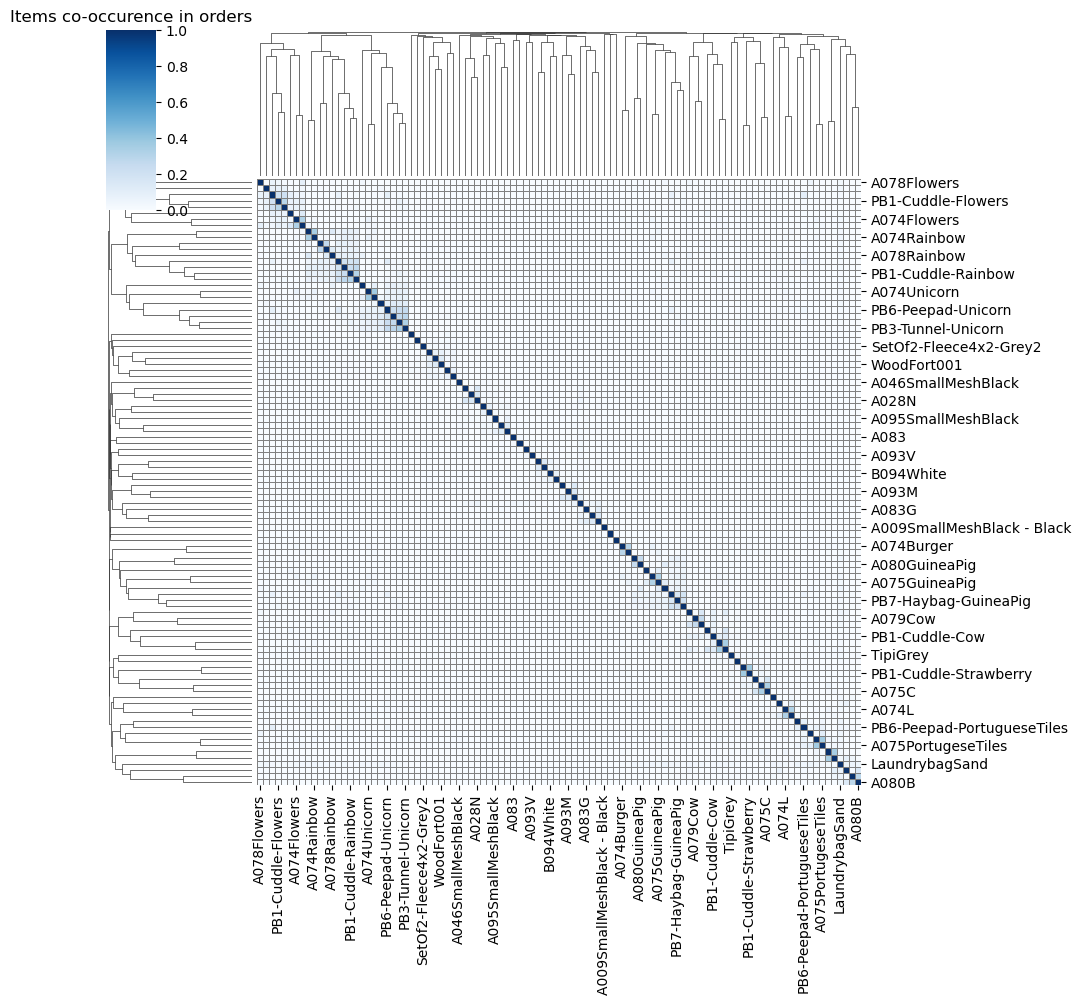

In [150]:
cmap = sns.color_palette("Blues", as_cmap=True)
data = same_basket_corr.iloc[:100,:100]
sns.clustermap(data, metric='correlation',cmap=cmap,linewidth=.5,linecolor='grey',vmin=min_corr)
plt.title('Items co-occurence in orders')